In [61]:
import warnings;
warnings.filterwarnings('ignore')

In [62]:
%pylab inline
import seaborn as sns
sns.set_style('darkgrid')
%config InlineBackend.figure_format = 'retina'
matplotlib.rcParams['figure.figsize'] = 19,14
sns.set_context('poster',font_scale=1.4)
import pandas as pd
import pyccl as ccl
from itertools import chain
from pprint import pprint
from math import fsum
import numdifftools as nd

Populating the interactive namespace from numpy and matplotlib


# Creating Photo-z Distributions

## Source galaxy distribution

### Creating 5 bins with equal number of source galaxies

source sample: 5 redshift bins defined with equal numbers of source galaxies per bins

In [29]:
# getting the n(z) distribution from the LSSTDESC/Requirements github repo for Y10 and i+r bands. 
# only using this for source galaxy binning.

df = pd.read_csv('nzdist.txt', sep=' ') 
df.head()

,zmid,dn,dneff
0,0.05,0.107288,0.101795
1,0.15,0.600815,0.497371
2,0.25,1.233816,0.946778
3,0.35,2.521276,1.889779
4,0.45,3.350079,2.331543


In [30]:
zmid = df['zmid']
dneff = df['dneff']

# turn zmid, dneff pairs into a histogrammable dataset.
datapts = ([list(np.ones(int(dneff[i]/min(dneff)))*zmid[i]) for i in range(len(zmid))])
datapts = list(chain.from_iterable(datapts)) # flatten

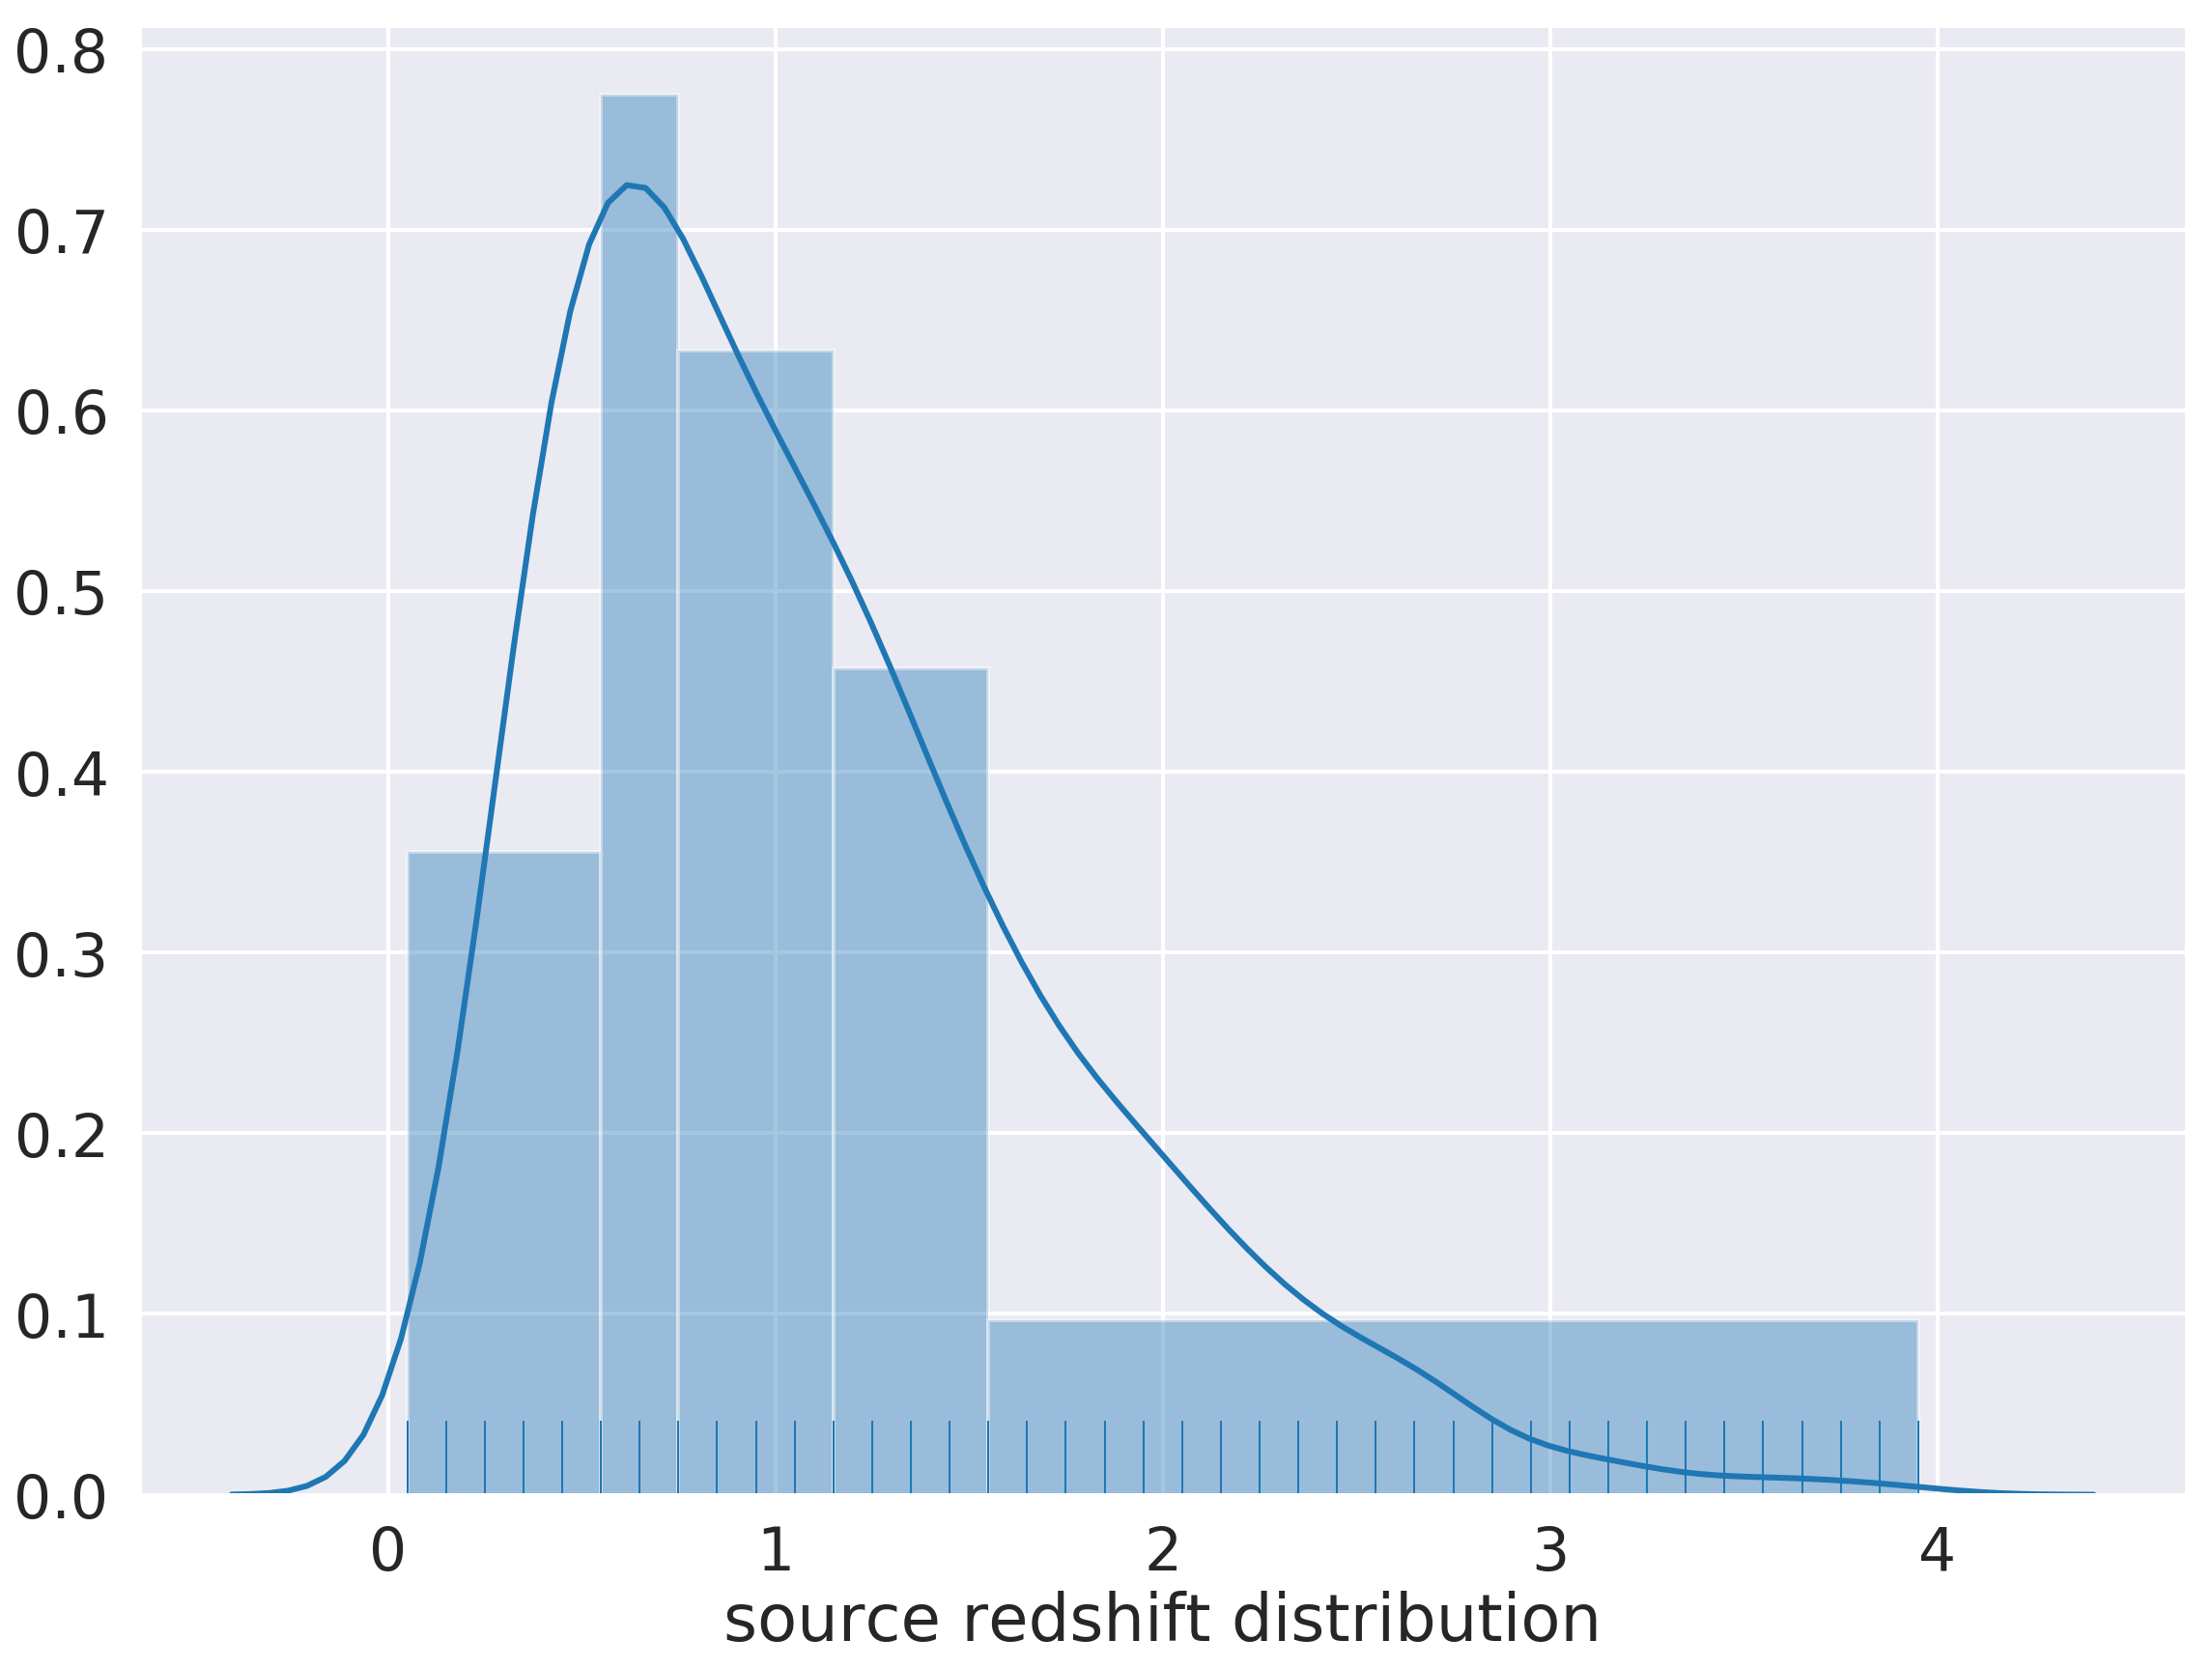

In [31]:
bins = datapts[0::int(len(datapts)/5)] # bin edges
sns.distplot(datapts, bins=bins, rug=True);
plt.xlabel('source redshift distribution');

In [32]:
bin_centers = [.5*fsum([bins[i]+bins[i+1]]) for i in range(len(bins[:-1]))]

### Create source dN/dz distribution

In [33]:
def photoz(z_ph, z_s, args=None):
    # sigma_z = 0.05*(1+z)
    return z_ph
    # return np.exp(- (z_ph - z_s)**2. / (2.*sigma_z**2.)) \
    #       * 1/np.sqrt(2*np.pi*sigma_z**2)

In [34]:
pz = ccl.PhotoZFunction(photoz)

In [35]:
z = np.linspace(0, 4, 121)
dNdz_dict_source = {}
for i, bin in enumerate(bins[:-1]):
    dNdz_dict_source[bin_centers[i]] = ccl.dNdz_tomog(z, 'wl_fid', bins[i], bins[i+1], pz)

In [20]:
dNdz_dict_source.keys()

dict_keys([0.30000000000000004, 0.65, 0.95, 1.35, 2.75])

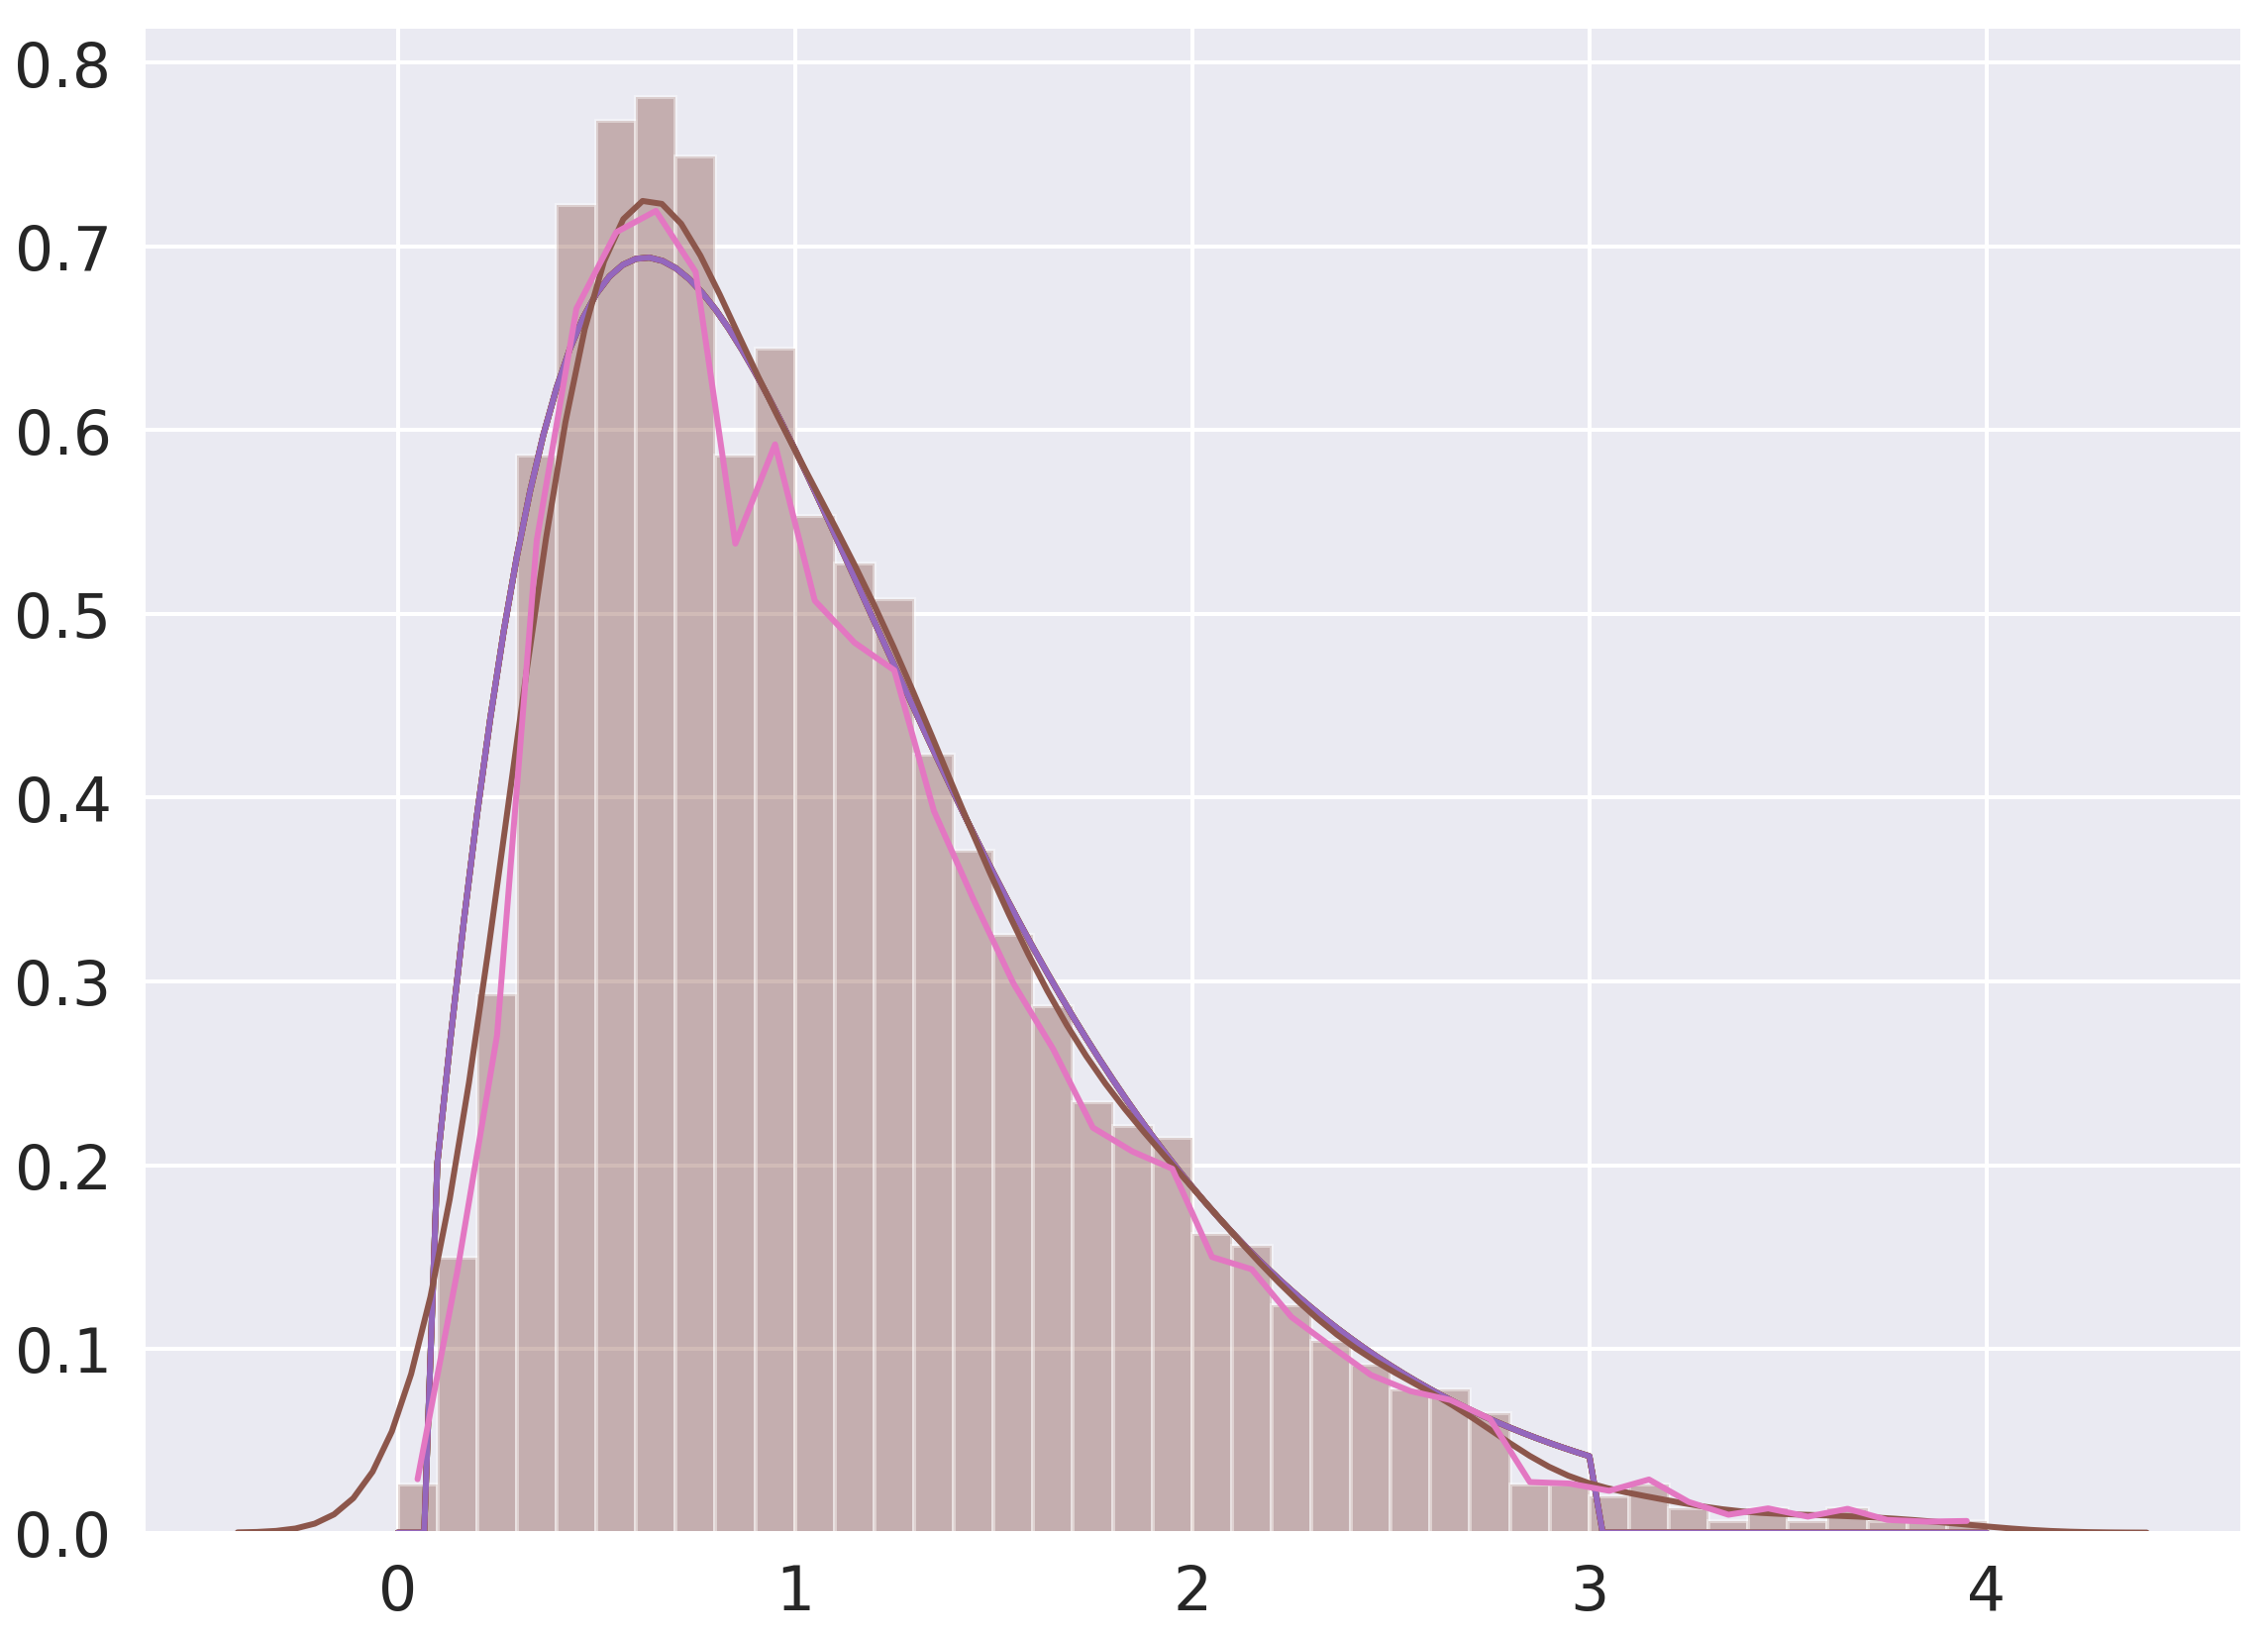

In [21]:
for key in dNdz_dict_source.keys():
    sns.lineplot(z, dNdz_dict_source[key], markers=False)
sns.distplot(datapts, bins=np.linspace(0,4,41));
plt.plot(df['zmid'], df['dneff']/3.5)

In [74]:
def photoz(z_ph, z_s, args=None):
    sigma_z = 0.05*(1+z_s)
    return np.exp(- (z_ph - z_s)**2. / (2.*sigma_z**2.)) \
                  * 1/np.sqrt(2*np.pi*sigma_z**2)

pz = ccl.PhotoZFunction(photoz)
z = np.linspace(0, 4, 120)
dNdz_dict_source = {}
for i, bin in enumerate(bins[:-1]):
    dNdz_dict_source[bin_centers[i]] = ccl.dNdz_tomog(z, 'wl_fid', bins[i], bins[i+1], pz)

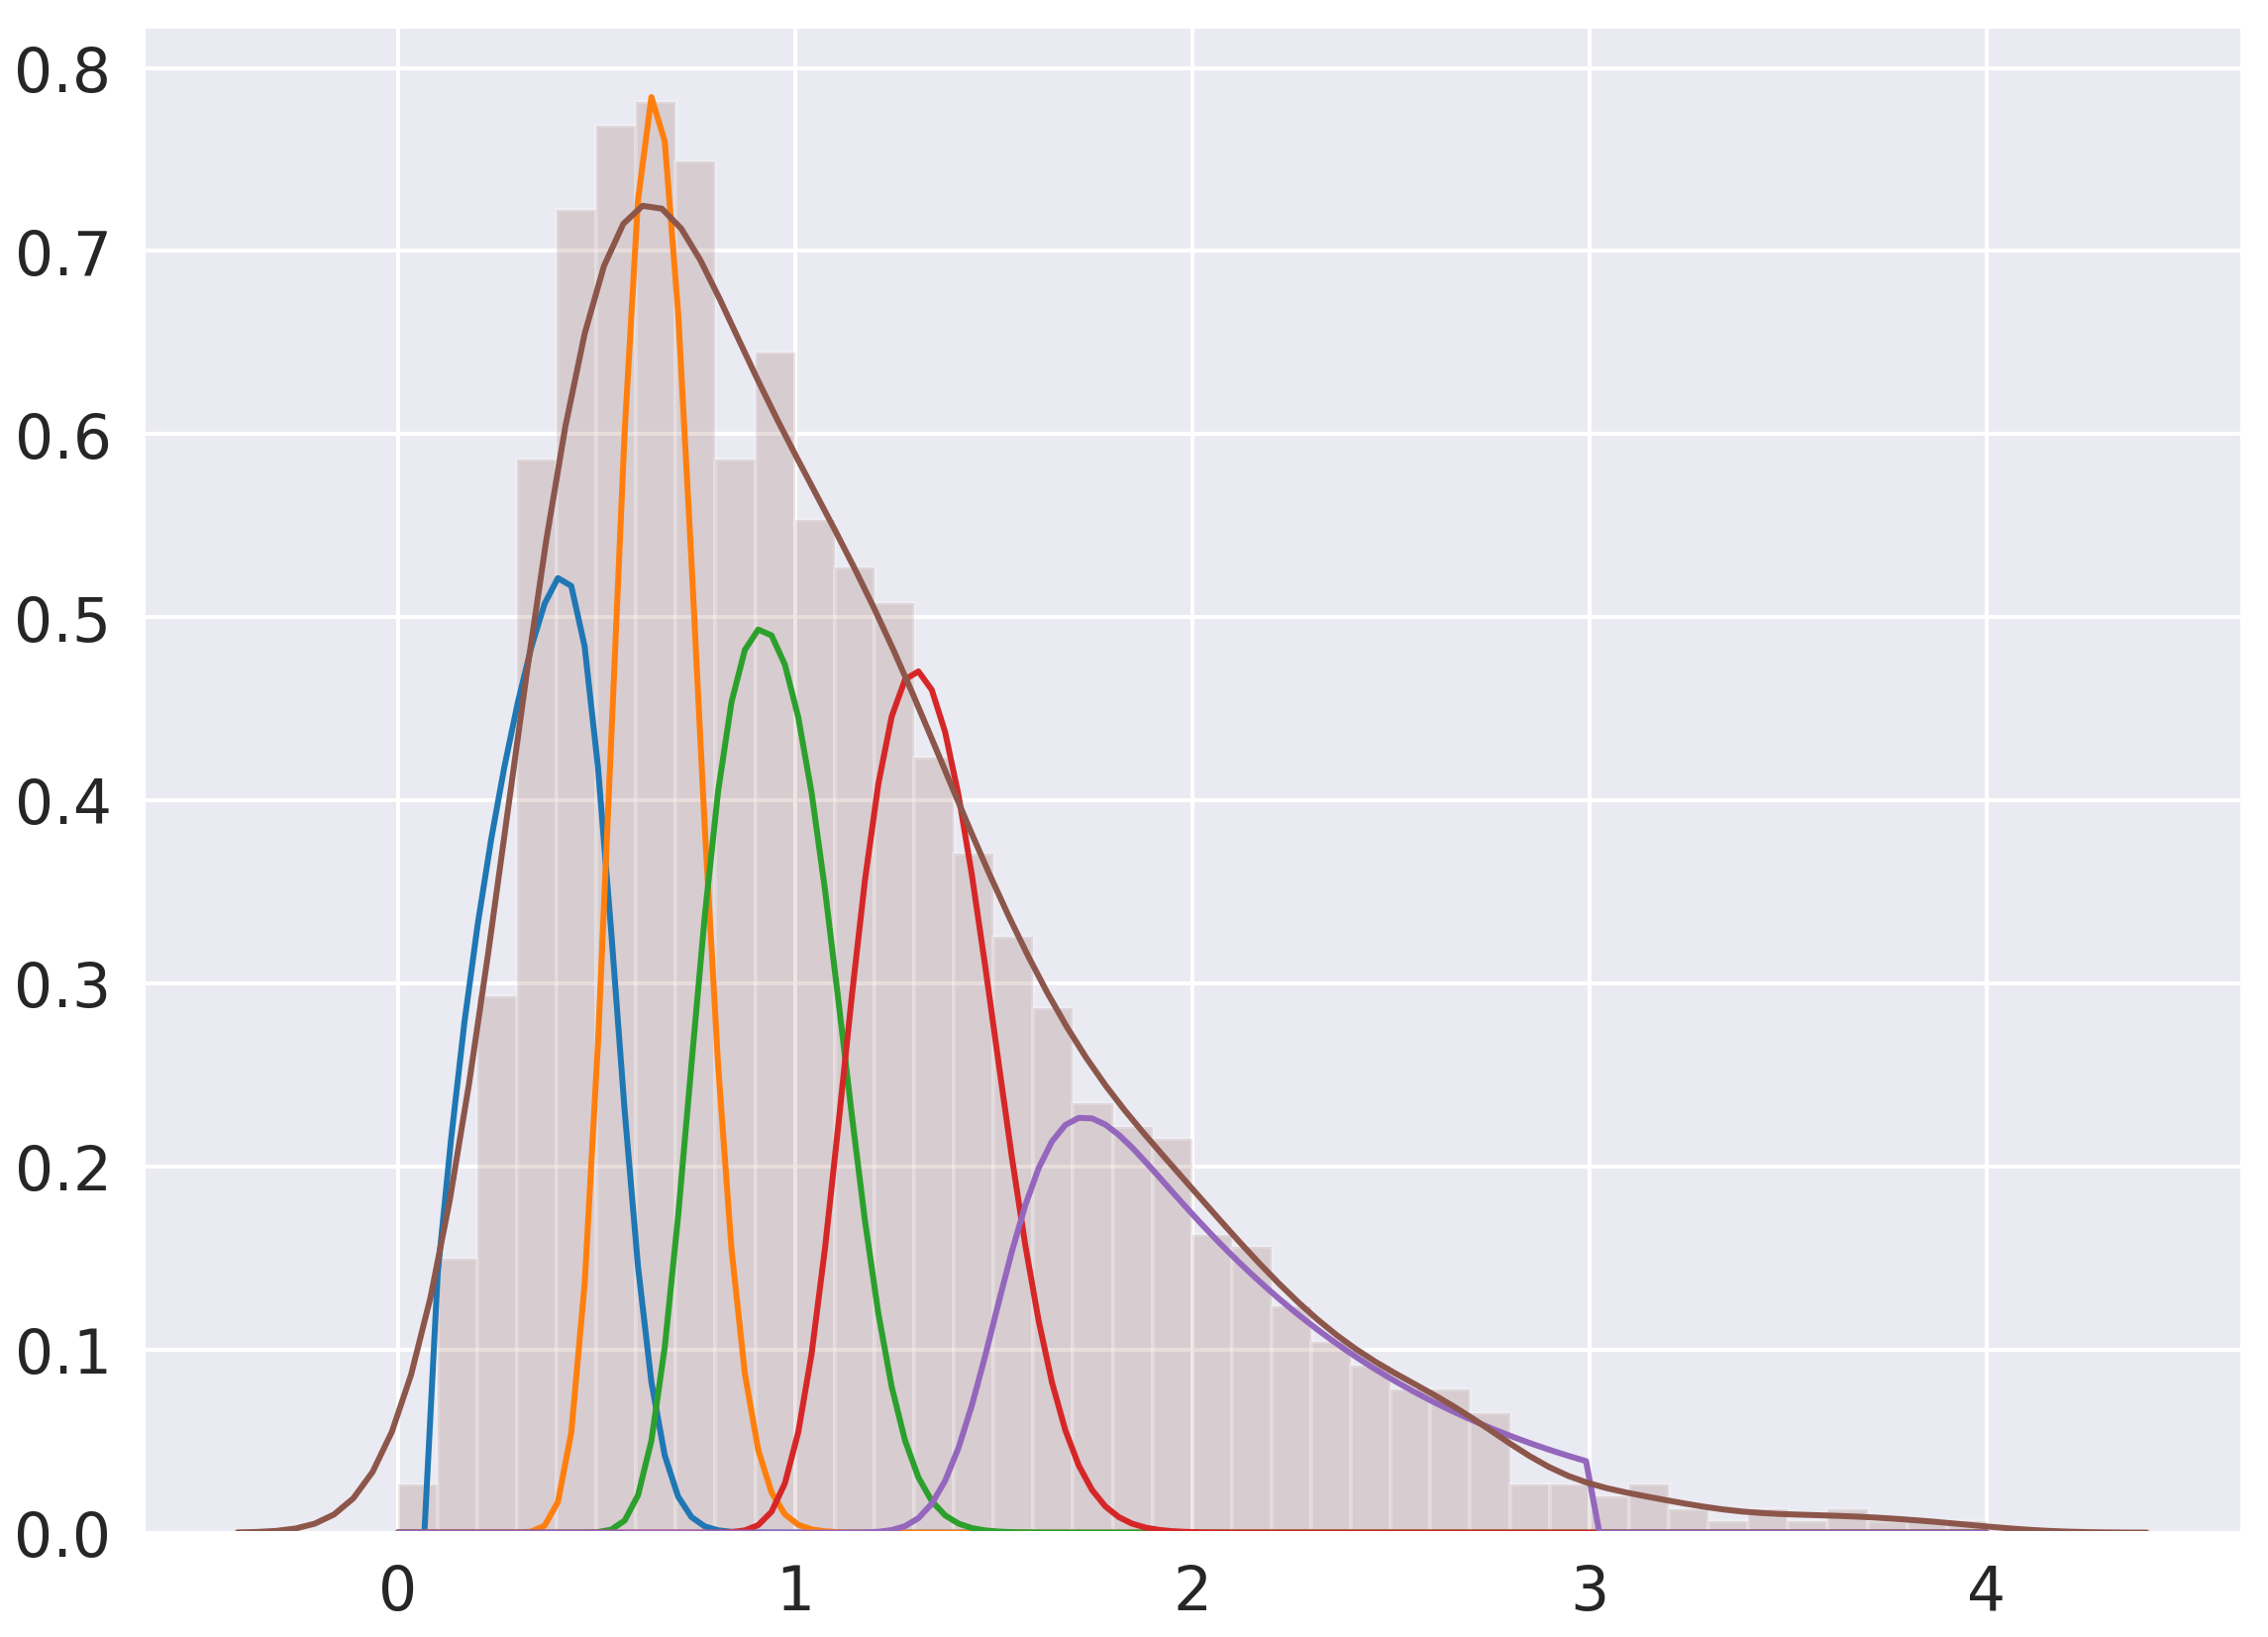

In [23]:
for key in dNdz_dict_source.keys():
    sns.lineplot(z, dNdz_dict_source[key]/5, markers=False)
sns.distplot(datapts, bins=np.linspace(0,4,41), hist_kws=dict(alpha=0.2));

## Lens redshift distribution:

lens sample: 10 redshift bins spaced by 0.1 from 0.2 to 1.2

$$ \frac{dN}{dz} = z^2 exp (- (\frac{z}{z_0})^\alpha) $$
with $$z_0 = 0.28$$ and $$\alpha = 0.9$$
and galaxy bias $$ b(z) = 0.95/G(z)$$ and scatter $$ \sigma_z = 0.03 (1+z) $$

In [24]:
def dNdz_lens(z, alpha=0.9, simga=0.03, zscale=0.28, bias=0.95):
    return  48 * z**2 * np.exp(- (z/zscale)**alpha) 

### Define bins

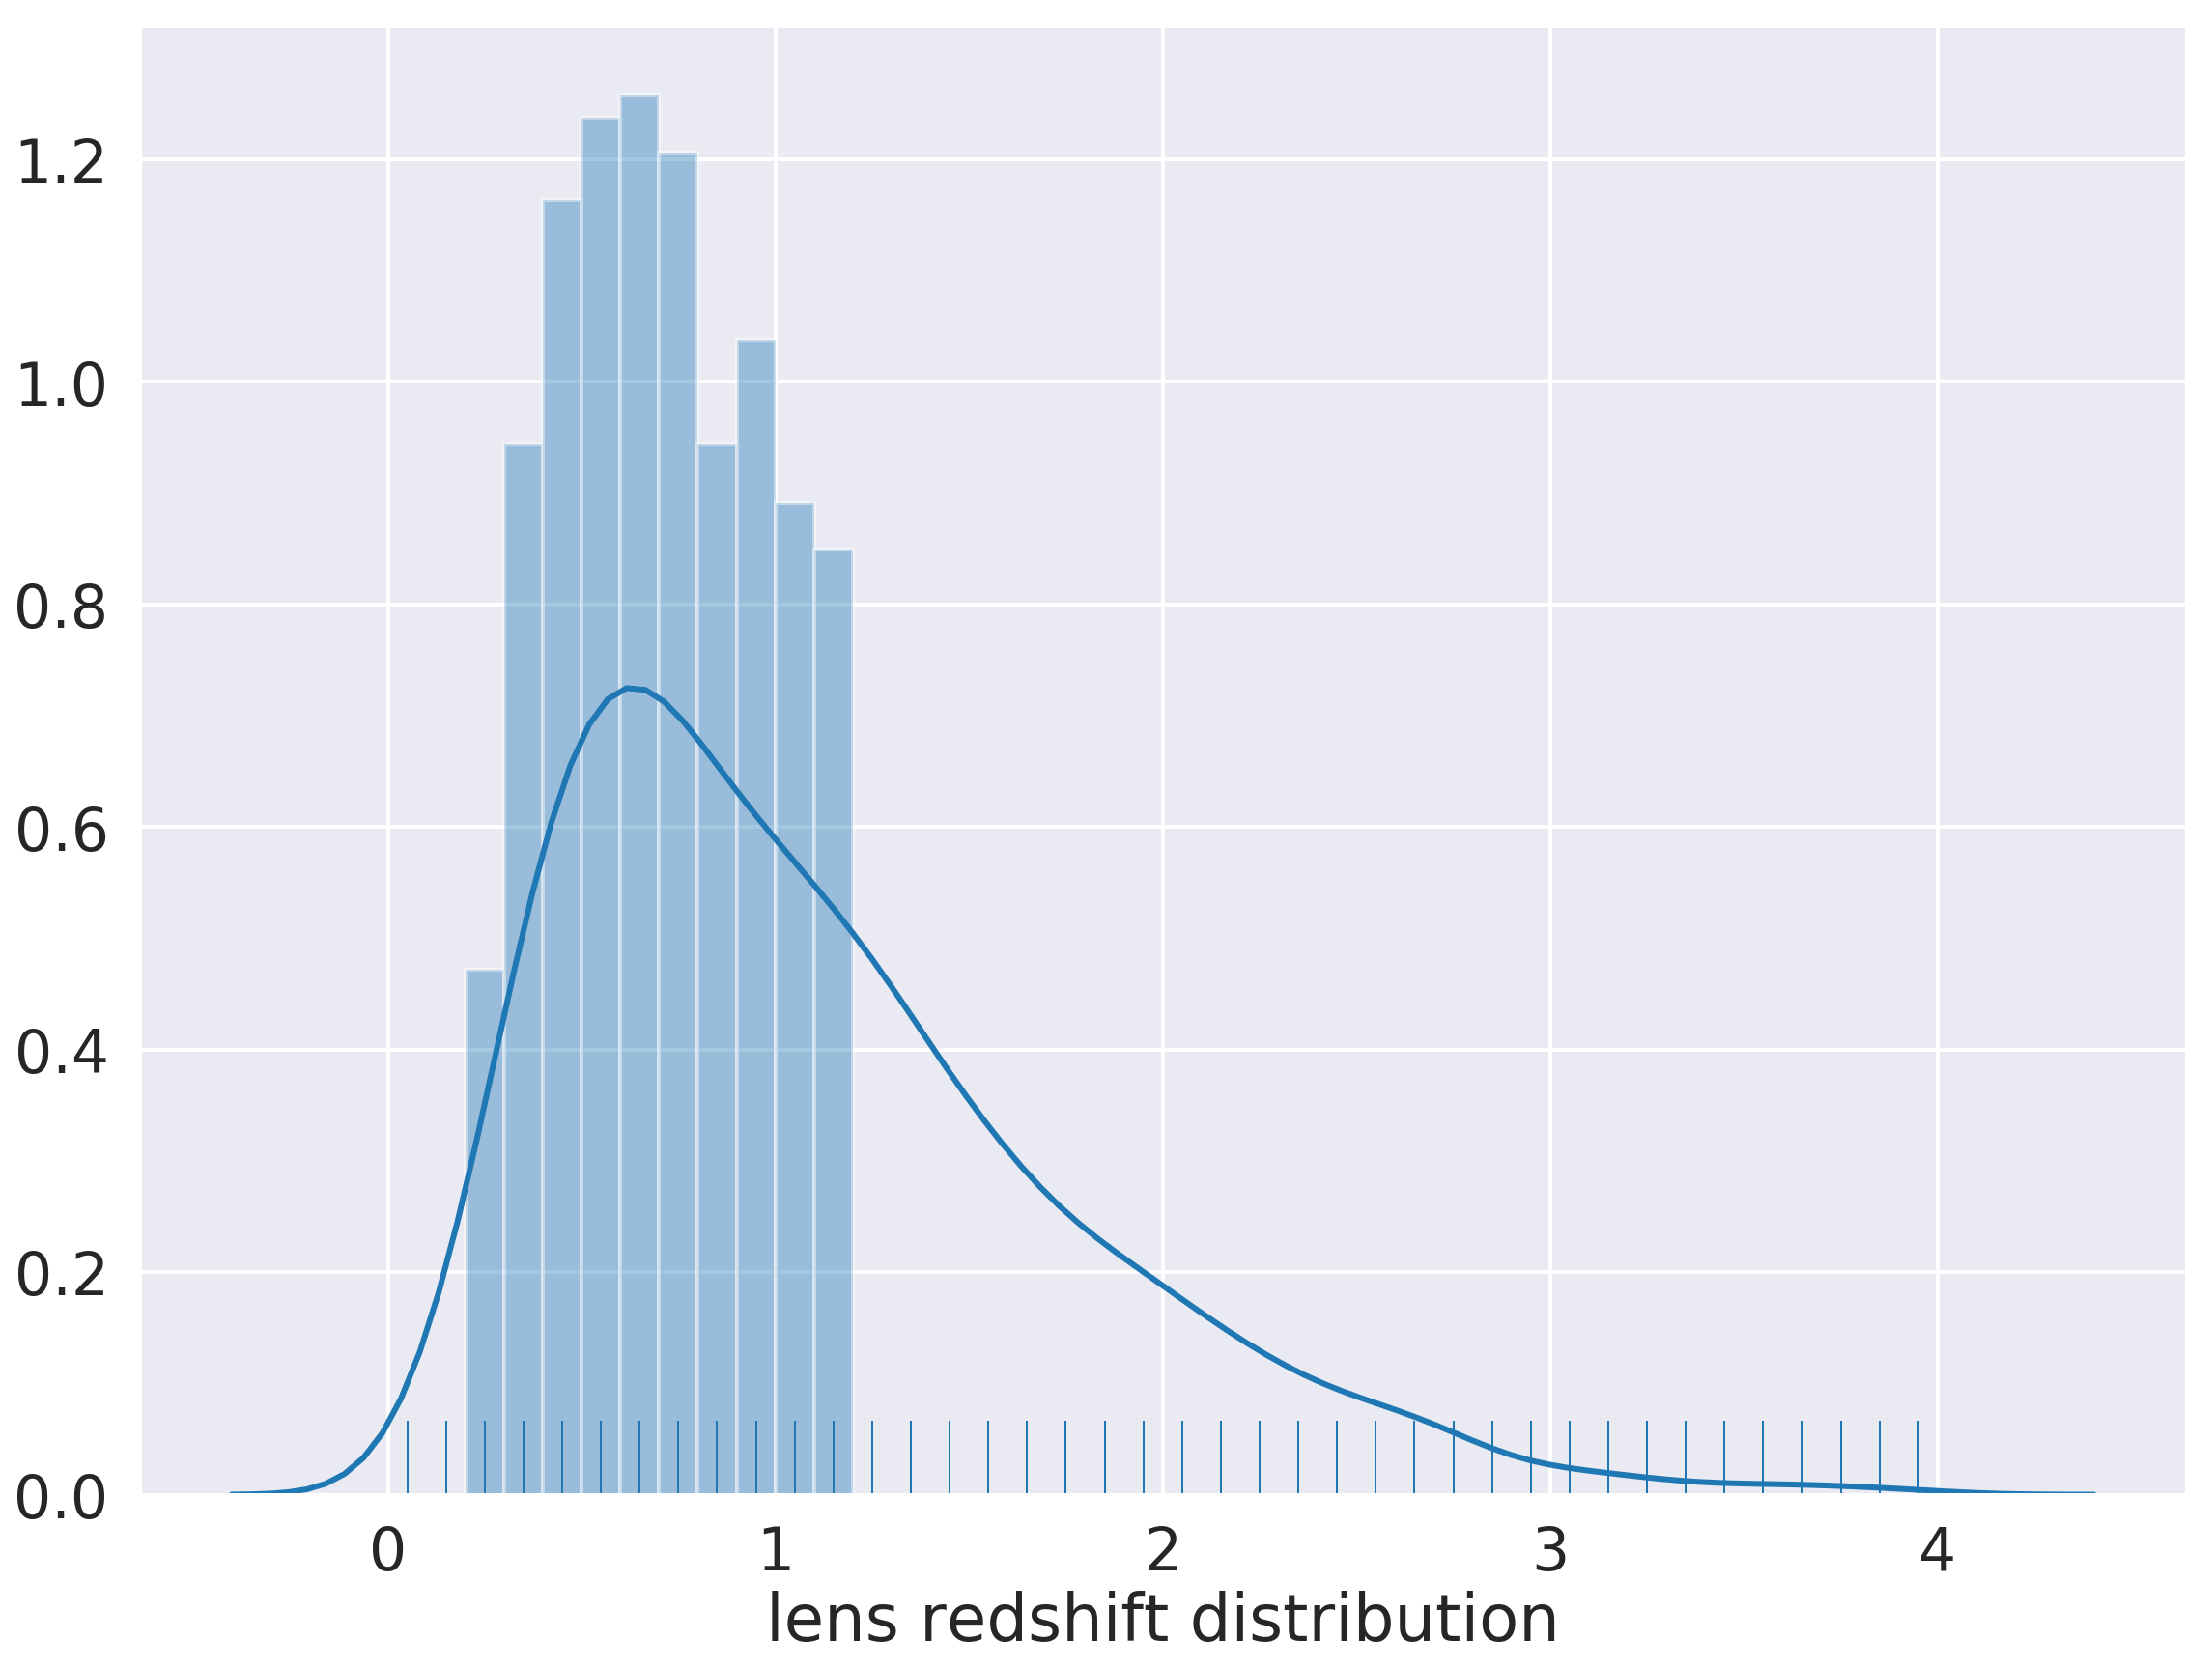

In [25]:
bins = np.linspace(0.2, 1.2, 11) # defines bin edges
z = np.linspace(0,2,21)
bin_centers = [fsum([bin+0.1]) for bin in bins][:-1]
sns.distplot(datapts, bins=bins, rug=True);
plt.xlabel('lens redshift distribution');

### Creating Lens dN/dz distribution 

In [72]:
def photoz(z_ph, z_s, args=None):
    sigma_z = 0.03*(1+z_s)
    return np.exp(-(z_ph - z_s)**2 / (2*sigma_z**2)) \
            * 1/np.sqrt(2*np.pi*sigma_z**2)
pz = ccl.PhotoZFunction(photoz) # creates 0.03 (1+z) Gaussian PZ function
z = np.linspace(0, 4, 121)
dNdz_dict_lens = {}
for i, bin in enumerate(bins[:-1]):
    dNdz_dict_lens[bin_centers[i]] = ccl.dNdz_tomog(z, 'wl_fid', bins[i], bins[i+1], pz)


Text(0,0.5,'n(z)')

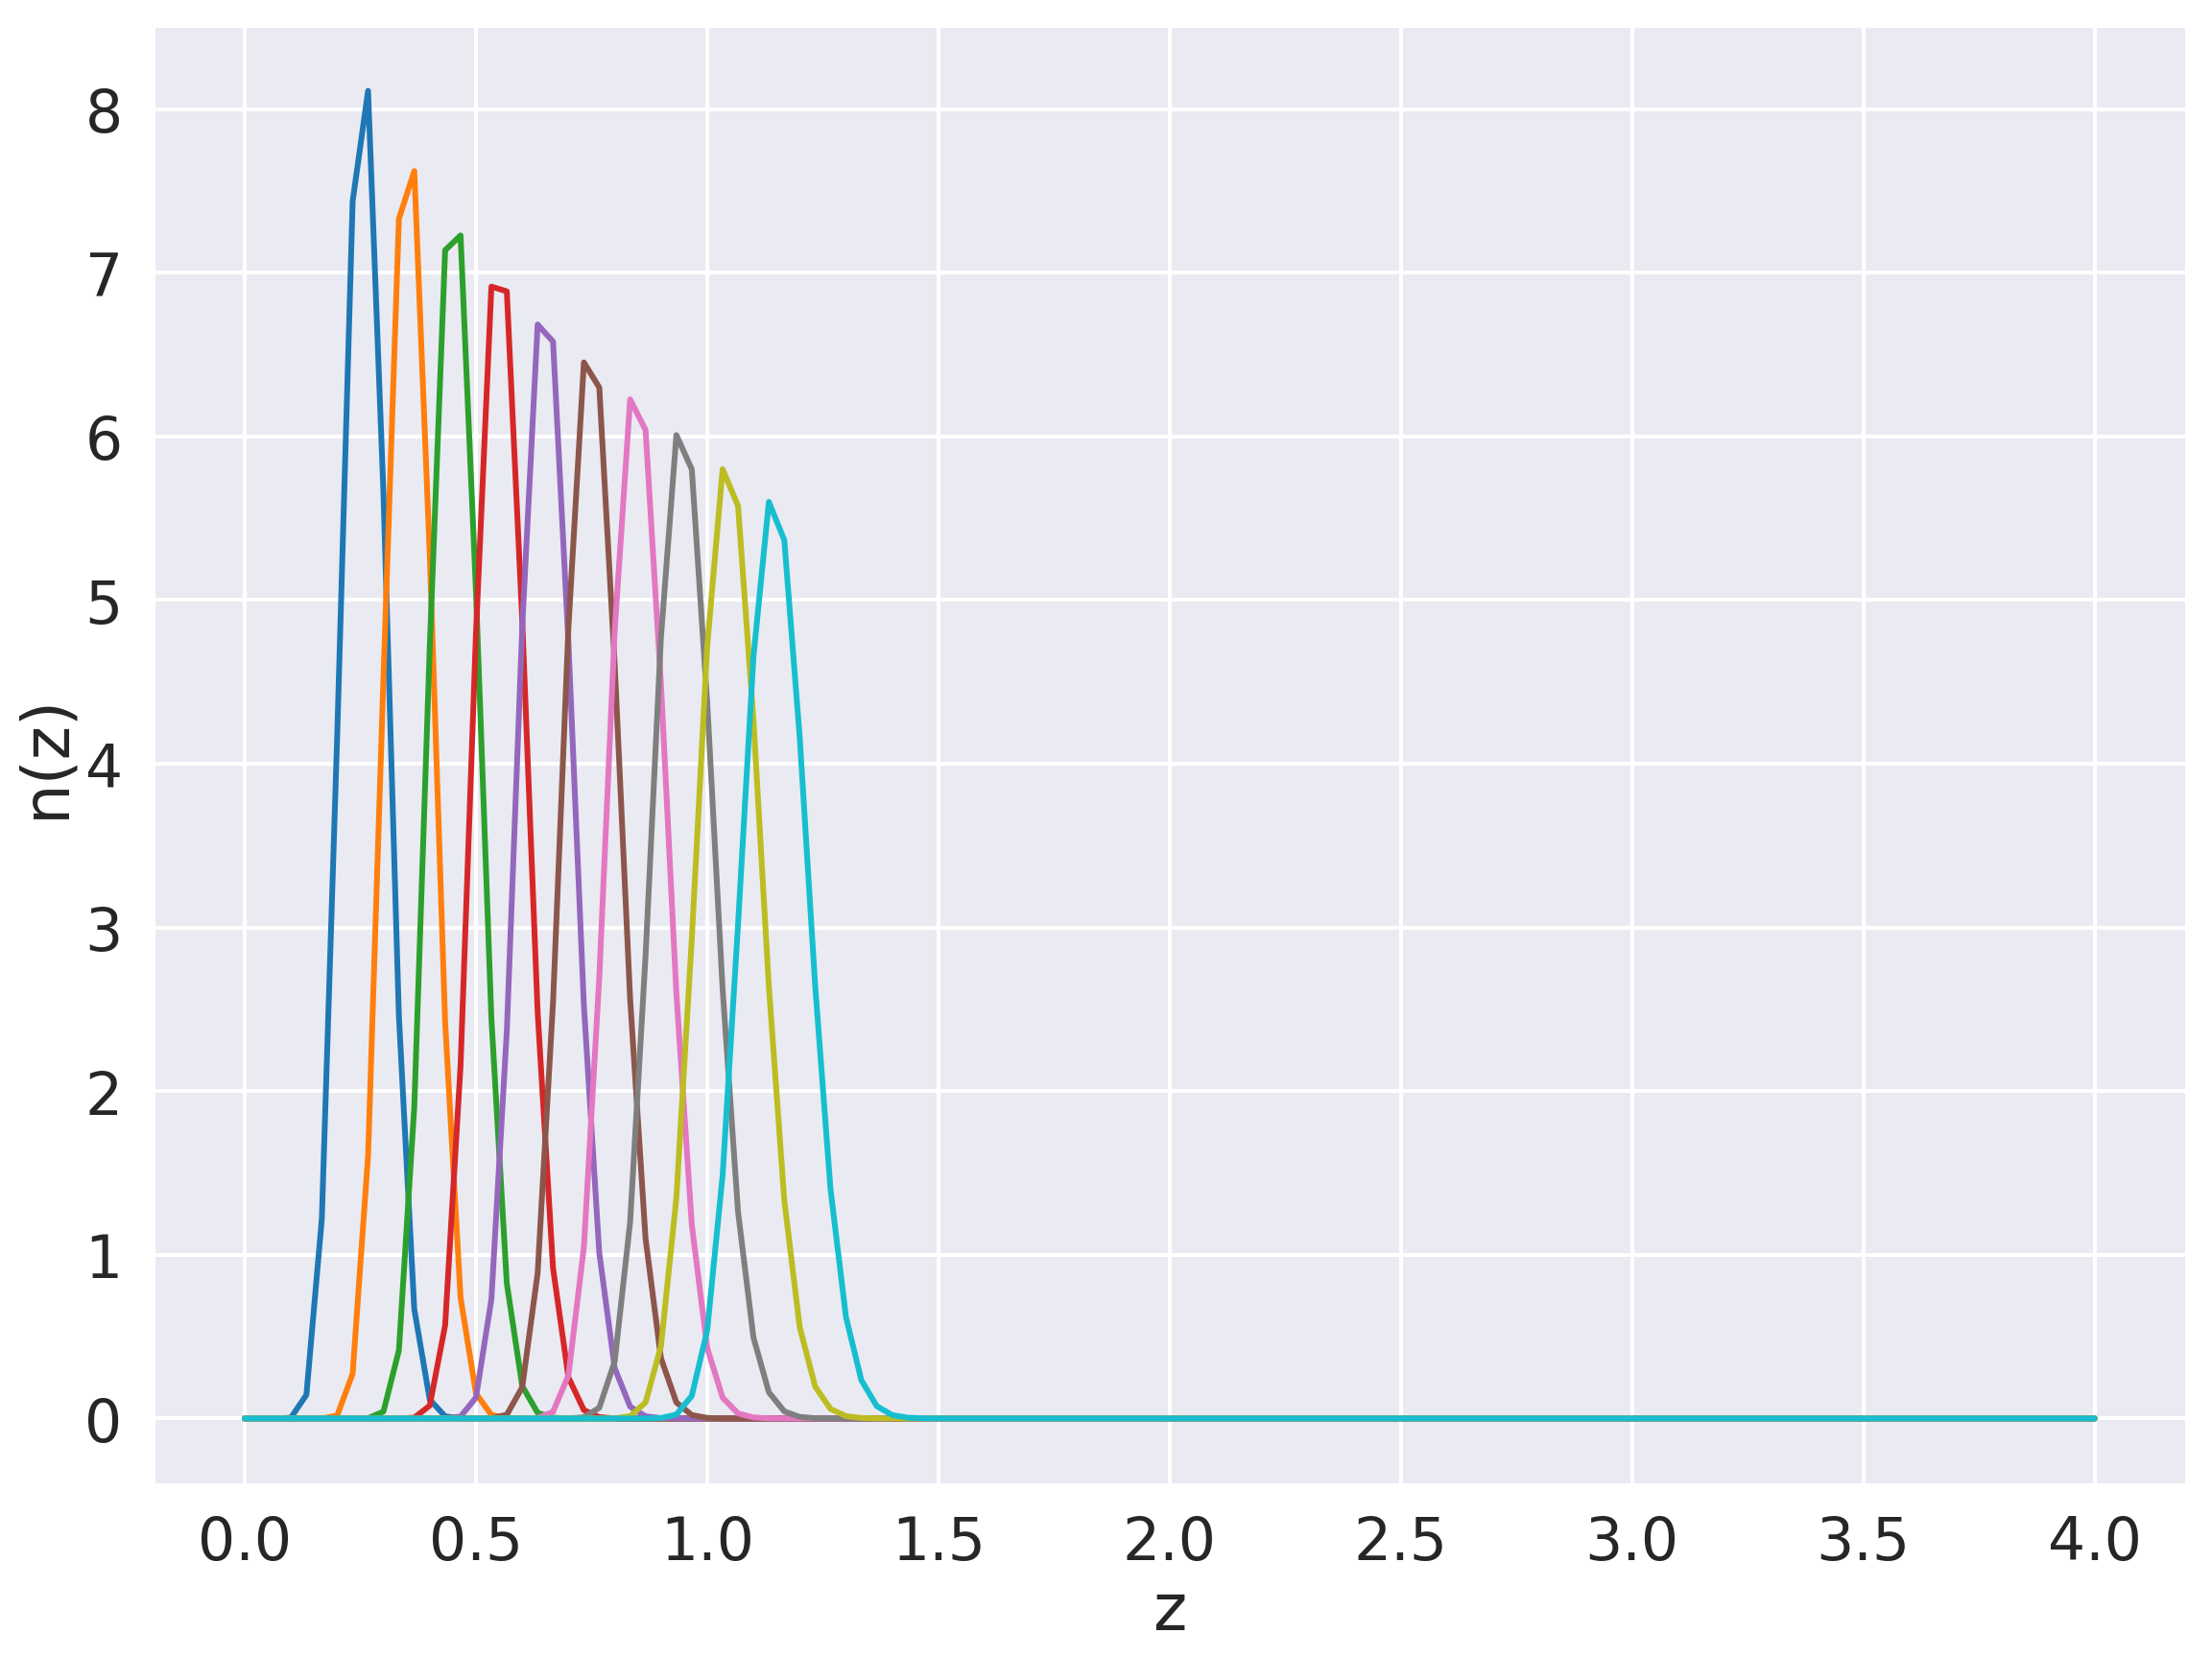

In [27]:
dNdz_lens_df = pd.DataFrame(dNdz_dict_lens)
for key in dNdz_lens_df.columns:
    sns.lineplot(x=z, y=dNdz_lens_df[key], data=dNdz_lens_df, markers=False)
plt.xlabel('z')
plt.ylabel('n(z)')

# Getting correlation functions from CCL

In [28]:
cosmo = ccl.Cosmology(Omega_c=0.2666, Omega_b=0.049, h=0.6727, sigma8=0.831, n_s=0.9645, transfer_function='eisenstein_hu')
pprint(cosmo)

pyccl.Cosmology(Omega_c=0.2666, Omega_b=0.049, h=0.6727, n_s=0.9645, sigma8=0.831, A_s=None, Omega_k=0.0, Omega_g=None, Neff=3.046, w0=-1.0, wa=0.0, bcm_log10Mc=14.079181246047625, bcm_etab=0.5, bcm_ks=55.0, m_nu=0.0, mnu_type=None, z_mg=None, df_mg=None, transfer_function='eisenstein_hu', matter_power_spectrum='halofit', baryons_power_spectrum='nobaryons', mass_function='tinker10', halo_concentration='duffy2008', emulator_neutrinos='strict')


## Getting shear and clustering tracers

In [50]:
list(ell.to_dict()['ell'].values())

[23.5997,
 32.8594,
 45.75227,
 63.70386,
 88.69901,
 123.5014,
 171.959,
 239.4297,
 333.3735,
 464.1775,
 646.3045,
 899.8917,
 1252.978,
 1744.602,
 2429.1220000000003,
 3382.225,
 4709.291,
 6557.052,
 9129.808,
 12712.02]

In [51]:
ell = pd.read_csv('ell-values', names=['ell'])
ell = list(ell.to_dict()['ell'].values())

In [81]:
z = np.linspace(0, 4, 121)

In [82]:
len(dNdz_dict_source[1.35])

120

In [83]:
ccl_cls = pd.DataFrame()
zbin = 0
j = 0

lst = list(dNdz_dict_source.keys())
for i, key in enumerate(lst):
    lens1 = ccl.WeakLensingTracer(cosmo, dndz=(z[1:], dNdz_dict_source[key]))
    for keyj in lst[i:]:
        lens2 = ccl.WeakLensingTracer(cosmo, dndz=(z[1:], dNdz_dict_source[keyj]))
        cls = ccl.angular_cl(cosmo, lens1, lens2, ell)
        newdf = pd.DataFrame({'zbin': [int(k) for k in j*np.ones(len(cls))],
                              'ell': ell,
                              'C_ell': cls})
        ccl_cls = pd.concat((ccl_cls, newdf))
        j += 1
        

ccl_cls = ccl_cls.reset_index()

In [84]:
ccl_cls[ccl_cls['ell']==100]

,index,C_ell,ell,zbin
90,90,9.004267e-10,100.0,0
1081,90,1.605402e-09,100.0,1
2072,90,1.917116e-09,100.0,2
3063,90,2.134584e-09,100.0,3
4054,90,2.302600e-09,100.0,4
5045,90,3.570314e-09,100.0,5
6036,90,4.791057e-09,100.0,6
7027,90,5.670541e-09,100.0,7
8018,90,6.350811e-09,100.0,8
9009,90,7.275193e-09,100.0,9


In [54]:
ccl_cls.head()

,index,C_ell,ell,zbin
0,0,6.757037e-09,23.59970,0
1,1,4.759331e-09,32.85940,0
2,2,3.129444e-09,45.75227,0
3,3,1.933258e-09,63.70386,0
4,4,1.122849e-09,88.69901,0


In [55]:
ccl_cls.describe()

,index,C_ell,ell,zbin
count,300.000000,3.000000e+02,300.000000,300.000000
mean,9.500000,5.186675e-09,2252.517477,7.000000
std,5.775916,1.068979e-08,3413.553209,4.327713
min,0.000000,1.072621e-14,23.599700,0.000000
25%,4.750000,4.888515e-12,114.800803,3.000000
50%,9.500000,2.098050e-10,555.241000,7.000000
75%,14.250000,4.625596e-09,2667.397750,11.000000
max,19.000000,6.656594e-08,12712.020000,14.000000


# the following cell runs all the necessary parts of all the previous cells

In [4]:

df = pd.read_csv('nzdist.txt', sep=' ') 
df.head()
zmid = df['zmid']
dneff = df['dneff']

# turn zmid, dneff pairs into a histogrammable dataset.
datapts = ([list(np.ones(int(dneff[i]/min(dneff)))*zmid[i]) for i in range(len(zmid))])
datapts = list(chain.from_iterable(datapts)) # flatten
bins = datapts[0::int(len(datapts)/5)] # bin edges
bin_centers = [.5*fsum([bins[i]+bins[i+1]]) for i in range(len(bins[:-1]))]
def photoz(z_ph, z_s, args=None):
    # sigma_z = 0.05*(1+z)
    return z_ph
    # return np.exp(- (z_ph - z_s)**2. / (2.*sigma_z**2.)) \
    #       * 1/np.sqrt(2*np.pi*sigma_z**2)
pz = ccl.PhotoZFunction(photoz)

z = np.linspace(0, 4, 121)
dNdz_dict_source = {}
for i, bin in enumerate(bins[:-1]):
    dNdz_dict_source[bin_centers[i]] = ccl.dNdz_tomog(z, 'wl_fid', bins[i], bins[i+1], pz)
def photoz(z_ph, z_s, args=None):
    sigma_z = 0.05*(1+z_s)
    return np.exp(- (z_ph - z_s)**2. / (2.*sigma_z**2.)) \
                  * 1/np.sqrt(2*np.pi*sigma_z**2)

pz = ccl.PhotoZFunction(photoz)
z = np.linspace(0, 4, 120)
dNdz_dict_source = {}
for i, bin in enumerate(bins[:-1]):
    dNdz_dict_source[bin_centers[i]] = ccl.dNdz_tomog(z, 'wl_fid', bins[i], bins[i+1], pz)
def dNdz_lens(z, alpha=0.9, simga=0.03, zscale=0.28, bias=0.95):
    return  48 * z**2 * np.exp(- (z/zscale)**alpha) 
bins = np.linspace(0.2, 1.2, 11) # defines bin edges
z = np.linspace(0,2,21)
bin_centers = [fsum([bin+0.1]) for bin in bins][:-1]

def photoz(z_ph, z_s, args=None):
    sigma_z = 0.03*(1+z_s)
    return np.exp(-(z_ph - z_s)**2 / (2*sigma_z**2)) \
            * 1/np.sqrt(2*np.pi*sigma_z**2)
pz = ccl.PhotoZFunction(photoz) # creates 0.03 (1+z) Gaussian PZ function
z = np.linspace(0, 4, 121)
dNdz_dict_lens = {}
for i, bin in enumerate(bins[:-1]):
    dNdz_dict_lens[bin_centers[i]] = ccl.dNdz_tomog(z, 'wl_fid', bins[i], bins[i+1], pz)

dNdz_lens_df = pd.DataFrame(dNdz_dict_lens)

ell = np.linspace(10, 1000, 991)
#ell = pd.read_csv('ell-values', names=['ell'])
#ell = list(ell.to_dict()['ell'].values())
cosmo = ccl.Cosmology(Omega_c=0.2666, Omega_b=0.049, h=0.6727, sigma8=0.831, n_s=0.9645, transfer_function='eisenstein_hu')


ccl_cls = pd.DataFrame()
zbin = 0
j = 0

lst = list(dNdz_dict_source.keys())
for i, key in enumerate(lst):
    lens1 = ccl.WeakLensingTracer(cosmo, dndz=(z[1:], dNdz_dict_source[key]))
    for keyj in lst[i:]:
        lens2 = ccl.WeakLensingTracer(cosmo, dndz=(z[1:], dNdz_dict_source[keyj]))
        cls = ccl.angular_cl(cosmo, lens1, lens2, ell)
        newdf = pd.DataFrame({'zbin': [int(k) for k in j*np.ones(len(cls))],
                              'ell': ell,
                              'C_ell': cls})
        ccl_cls = pd.concat((ccl_cls, newdf))
        j += 1
        

ccl_cls = ccl_cls.reset_index()

In [5]:
"""This program predicts the theoretical covariance matrix
for LSS for each row in the input file


USES the cosmosis format

Author: MMRAU
"""

import sys
import numpy as np

 
def get_cov_matrix(l, data_order, cl_vals, orderings, fsky):
    """
    Return the covariance matrix
    Parameters:
    l: mode number
    data_order: order of the data vector
    cl_vals: numpy vector shotnoise already added for lookup purposes
    orderings: bin_ordering of the inputs for lookup purposes
    fsky: sky benefit
    number_density values: shot noise component
    """
    prefac = 1.0/(2.0*l + 1.0)/fsky
    out_cov = np.zeros((len(data_order), len(data_order)))
    for z in range(out_cov.shape[0]):
        for y in range(out_cov.shape[1]):
            i = data_order[z][0]
            j = data_order[z][1]
            k = data_order[y][0]
            l = data_order[y][1]

            try:
                cl_ik = cl_vals[orderings.index([i, k])]
            except ValueError:
                #this happens if only autocorrelation is queried
                cl_ik = 0.0

            try:
                cl_jl = cl_vals[orderings.index([j, l])]
            except ValueError:
                cl_jl = 0.0

            try:
                cl_il = cl_vals[orderings.index([i, l])]
            except ValueError:
                cl_il = 0.0

            try:
                cl_jk = cl_vals[orderings.index([j, k])]
            except ValueError:
                cl_jk = 0.0

            out_cov[z, y] = prefac * (cl_ik*cl_jl + cl_il*cl_jk)
    return out_cov

def multi_bin_cov(fsky, Clbins, Cl_ordering, num_dens): 
        #first column --> l values

    combination_cl = Clbins[:, 0]
    orderings = []
    for i in range(1, Clbins.shape[1]):
        #Cl_orderings has no l entry
        index_comb = Cl_ordering[i-1, :].tolist()
        if index_comb[0] != index_comb[1]:
            #add the entry plus the
            #reversed entry --> would NOT be valid for cross correlations since different
            #bins!!!
            combination_cl = np.column_stack((combination_cl, Clbins[:, i]))
            combination_cl = np.column_stack((combination_cl, Clbins[:, i]))
            orderings.append(index_comb)
            orderings.append([index_comb[1], index_comb[0]])
        else:
            #autocorrelations
            combination_cl = np.column_stack((combination_cl, Clbins[:, i]))
            orderings.append(index_comb)

    #remove the first column from combination_cl --> makes it easier since now
    #it corresponds to orderings vector

    combination_cl = combination_cl[:, 1:]

    assert len(orderings) == combination_cl.shape[1]

    #add the shotnoise to each of the cl combinations:
    # TODO: make this an option for clustering vs lensing
    shotnoise = []
    for el in orderings:
        shotnoise.append(1.0/num_dens[int(el[0] - 1)])  # because ordering starts with 1
    shotnoise = np.array(shotnoise)
    assert len(shotnoise) == combination_cl.shape[1]

    for i in range(combination_cl.shape[1]):
        #only the autocorrelation is affected by shot noise
        if orderings[i][0] == orderings[i][1]:
            combination_cl[:, i] += shotnoise[i]

    #now calculate the covariance matrice for each of the Cl_orderings
    out_mat = []
    for i in range(Clbins.shape[0]):
        curr_l = Clbins[i, 0]
        matrix_out = get_cov_matrix(curr_l, Cl_ordering, combination_cl[i, :], orderings, fsky)
        out_mat.append(matrix_out)
    return out_mat
        #np.savetxt(X=matrix_out, fname=out_filename+str(curr_l)+".mat")

def one_bin_cov(fsky, Clbins, num_dens): 
    added_shotnoise = (Clbins[:, 1] + 1.0/num_dens)**2
    prefactor = 2.0/((2.0 * Clbins[:, 0] + 1.)*fsky) 
    covariance = prefactor * added_shotnoise 
    cov_matrix = np.diag(covariance)
    return cov_matrix
    #np.savetxt(X=cov_matrix, fname=out_filename+"onebin.mat")
    



In [6]:
numdens = [2*5.95e7/0.28**2]*5 
fsky = 0.4
C_ells = []
for i in set(ccl_cls['zbin']):
    C_ells.append(list(ccl_cls[ccl_cls['zbin']==i]['C_ell']))
l = []
for j in range(5):
    l.extend([[j, j+i] for i in range(5-j)])
ordering = np.array(l)
cl_bins= np.vstack((ell, C_ells)).T
cov_matrix_list = multi_bin_cov(fsky, cl_bins, ordering, numdens)

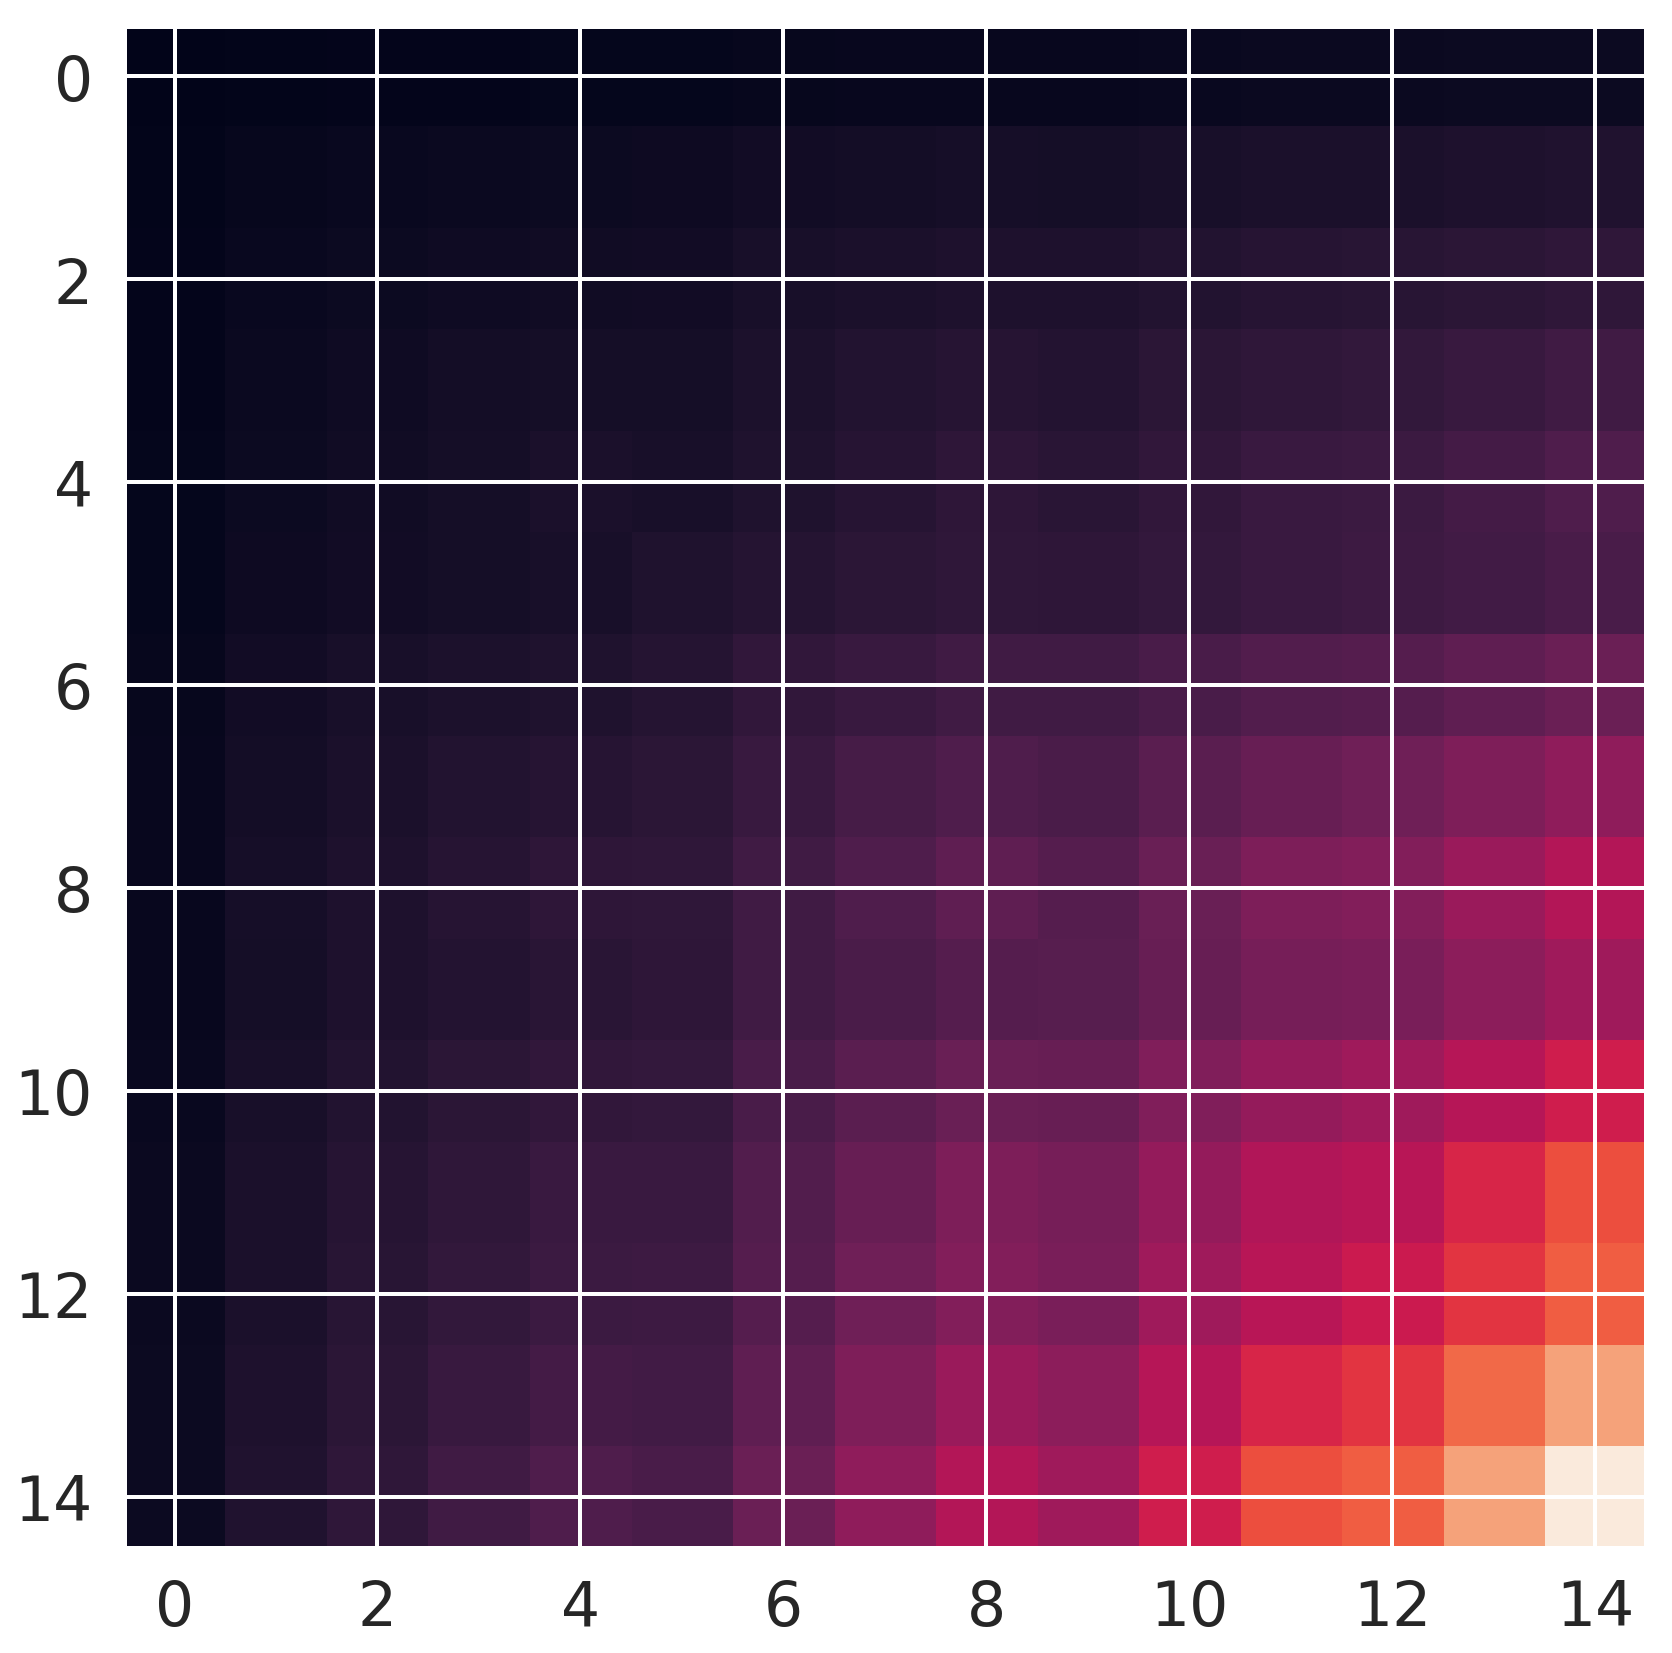

In [32]:
plt.imshow(cov_matrix_list[10])

In [7]:
invcov_list = []
for cov_l in cov_matrix_list:
    invcov_list.append(np.linalg.inv(cov_l))

In [51]:
params = dict(Omega_c=0.2666, Omega_b=0.049, h=0.6727, sigma8=0.381, n_s=0.9645, transfer_function='eisenstein_hu')

In [150]:
list(fid_params.keys())

['Omega_c', 'Omega_b', 'h', 'sigma8', 'n_s', 'wa', 'w0', 'transfer_function']

In [149]:
[param for param in param_order if param not in list(fid_params.keys())]

[]

In [197]:
f = functions[1]

In [32]:
d['Omega_c'](0)

NameError: name 'd' is not defined

In [235]:
d

{}

In [180]:
missing

['h']

In [33]:
from functools import partial

In [ ]:
functions = []

In [282]:
d = {}
param_order = ['Omega_c', 'sigma8', 'n_s', 'w0', 'wa', 'Omega_b']
fid_params = dict(Omega_c=0.2666, Omega_b=0.049, h=0.6727, sigma8=0.831, n_s=0.9645, wa=0, w0=-1, transfer_function='eisenstein_hu')
functions = []
for param in (param_order):
    new_params = fid_params.copy()
    del new_params[param]
    missing = [param for param in param_order if param not in list(new_params.keys())]
    print(missing)
    def f(param=param, missing=missing):
        print(param)
        print(missing)
        new_params[missing[0]] = param
        print(new_params)
        cosmo = ccl.Cosmology(**new_params)
        return cosmo
    d[param] = partial(f)
    


['Omega_c']
['sigma8']
['n_s']
['w0']
['wa']
['Omega_b']


In [284]:
d['w0'](param=2)

2
['w0']
{'Omega_c': 0.2666, 'h': 0.6727, 'sigma8': 0.831, 'n_s': 0.9645, 'wa': 0, 'w0': 2, 'transfer_function': 'eisenstein_hu'}


ValueError: Necessary parameter 'Omega_b' was not set (or set to None).

In [233]:
d = {}
param_order = ['Omega_c', 'sigma8', 'n_s', 'w0', 'wa', 'Omega_b']
fid_params = dict(Omega_c=0.2666, Omega_b=0.049, h=0.6727, sigma8=0.831, n_s=0.9645, wa=0, w0=-1, transfer_function='eisenstein_hu')
functions = []
for param in param_order:
    new_params = fid_params.copy()
    del new_params[param]
    missing = [param for param in param_order if param not in list(new_params.keys())]
    def f_factory(i):
        def f(param):
            new_params[missing[0]] = param
            print(new_params)
            cosmo = ccl.Cosmology(**new_params)
            return cosmo
        return f

for i in param_order:           
    f = f_factory(i)
    functions.append(f)

In [222]:
functions[5](1)

pyccl.Cosmology(Omega_c=0.2666, Omega_b=1, h=0.6727, n_s=0.9645, sigma8=0.831, A_s=None, Omega_k=0.0, Omega_g=None, Neff=3.046, w0=-1, wa=0, bcm_log10Mc=14.079181246047625, bcm_etab=0.5, bcm_ks=55.0, m_nu=0.0, mnu_type=None, z_mg=None, df_mg=None, transfer_function='eisenstein_hu', matter_power_spectrum='halofit', baryons_power_spectrum='nobaryons', mass_function='tinker10', halo_concentration='duffy2008', emulator_neutrinos='strict')

In [8]:
cosmo = ccl.Cosmology(Omega_c=0.2666, Omega_b=0.049, h=0.6727, sigma8=0.831, n_s=0.9645, transfer_function='eisenstein_hu')

In [9]:
def getC_ellOfSigma8(sigma8):
    cosmo = ccl.Cosmology(Omega_c=0.2666, Omega_b=0.049, h=0.6727, sigma8=sigma8, n_s=0.9645, transfer_function='eisenstein_hu')
    lens1 = ccl.WeakLensingTracer(cosmo, dndz=(z[1:], dNdz_dict_source[key]))
    lens2 = ccl.WeakLensingTracer(cosmo, dndz=(z[1:], dNdz_dict_source[keyj]))
    cls = ccl.angular_cl(cosmo, lens1, lens2, ell)
    
    return cls
def getC_ellOfOmegab(Omega_b):
    cosmo = ccl.Cosmology(Omega_c=0.2666, Omega_b=Omega_b, h=0.6727, sigma8=0.831, n_s=0.9645, transfer_function='eisenstein_hu')
    lens1 = ccl.WeakLensingTracer(cosmo, dndz=(z[1:], dNdz_dict_source[key]))
    lens2 = ccl.WeakLensingTracer(cosmo, dndz=(z[1:], dNdz_dict_source[keyj]))
    cls = ccl.angular_cl(cosmo, lens1, lens2, ell)
    
    return cls
def getC_ellOfh(h):
    cosmo = ccl.Cosmology(Omega_c=0.2666, Omega_b=0.049, h=h, sigma8=0.831, n_s=0.9645, transfer_function='eisenstein_hu')
    lens1 = ccl.WeakLensingTracer(cosmo, dndz=(z[1:], dNdz_dict_source[key]))
    lens2 = ccl.WeakLensingTracer(cosmo, dndz=(z[1:], dNdz_dict_source[keyj]))
    cls = ccl.angular_cl(cosmo, lens1, lens2, ell)
    
    return cls
def getC_ellOfn_s(n_s):
    cosmo = ccl.Cosmology(Omega_c=0.2666, Omega_b=0.049, h=0.6727, sigma8=0.831, n_s=n_s, transfer_function='eisenstein_hu')
    lens1 = ccl.WeakLensingTracer(cosmo, dndz=(z[1:], dNdz_dict_source[key]))
    lens2 = ccl.WeakLensingTracer(cosmo, dndz=(z[1:], dNdz_dict_source[keyj]))
    cls = ccl.angular_cl(cosmo, lens1, lens2, ell)
    
    return cls
def getC_ellOfOmegam(Omega_m):
    cosmo = ccl.Cosmology(Omega_c=Omega_m-0.049, Omega_b=0.049, h=0.6727, sigma8=0.831, n_s=0.9645, transfer_function='eisenstein_hu')
    lens1 = ccl.WeakLensingTracer(cosmo, dndz=(z[1:], dNdz_dict_source[key]))
    lens2 = ccl.WeakLensingTracer(cosmo, dndz=(z[1:], dNdz_dict_source[keyj]))
    cls = ccl.angular_cl(cosmo, lens1, lens2, ell)
    
    return cls
def getC_ellOfw0(w_0):
    cosmo = ccl.Cosmology(Omega_c=0.2666, Omega_b=0.049, h=0.6727, sigma8=0.831, n_s=0.9645, w0=w_0, transfer_function='eisenstein_hu')
    lens1 = ccl.WeakLensingTracer(cosmo, dndz=(z[1:], dNdz_dict_source[key]))
    lens2 = ccl.WeakLensingTracer(cosmo, dndz=(z[1:], dNdz_dict_source[keyj]))
    cls = ccl.angular_cl(cosmo, lens1, lens2, ell)
    
    return cls
def getC_ellOfwa(w_a):
    cosmo = ccl.Cosmology(Omega_c=0.2666, Omega_b=0.049, h=0.6727, sigma8=0.831, n_s=0.9645, wa=w_a, transfer_function='eisenstein_hu')
    lens1 = ccl.WeakLensingTracer(cosmo, dndz=(z[1:], dNdz_dict_source[key]))
    lens2 = ccl.WeakLensingTracer(cosmo, dndz=(z[1:], dNdz_dict_source[keyj]))
    cls = ccl.angular_cl(cosmo, lens1, lens2, ell)
    
    return cls

In [10]:
funcs = {
    'sigma_8': getC_ellOfSigma8,
    'omega_b': getC_ellOfOmegab,
    'h': getC_ellOfh,
    'n_s': getC_ellOfn_s,
    'omega_m': getC_ellOfOmegam,
    'w_0': getC_ellOfw0,
    'w_a': getC_ellOfwa
}
vals = {
    'sigma_8': 0.831, 
    'omega_b': 0.049, 
    'h': 0.6727, 
    'n_s': 0.9645, 
    'omega_m': 0.3156,
    'w_0': -1,
    'w_a': 0
}

In [11]:
derivs_sig = {}
for var in funcs.keys():
    print(var)
    zbin = 0
    j = 0
    derivs = []
    lst = list(dNdz_dict_source.keys())
    for i, key in enumerate(lst):    
        for keyj in lst[i:]:
            f = nd.Derivative(funcs[var], full_output=True, step=0.01)
            val, info = f(vals[var])

            derivs.append(val)
    derivs_sig[var] = np.array(derivs).T

sigma_8
omega_b
h
n_s
omega_m
w_0
w_a


In [326]:
param_order = ['omega_m', 'sigma_8', 'n_s', 'w_0', 'w_a', 'omega_b', 'h']
param_labels = [r'$\Omega_m$', r'$\sigma_8$', r'$n_s$', r'$w_0$', r'$w_a$', r'$\Omega_b$', r'$h$']
fisher = np.zeros((7,7))
for i, var1 in enumerate(param_order):
    for j, var2 in enumerate(param_order):
        f = []
        for l in range(len(derivs_sig[var1])):
            res = derivs_sig[var1][l].T @ invcov_list[l] @ derivs_sig[var2][l]
            f.append(res)
        fisher[i][j] = sum(f)

In [287]:
fisher

array([[ 2.81400438e+06,  1.33496807e+06,  5.24888260e+05,
        -2.41201760e+05, -5.03508208e+04,  1.65297035e+06,
         3.12576594e+05],
       [ 1.33496807e+06,  7.17857291e+05,  2.13387358e+05,
        -1.18543446e+05, -2.68121656e+04,  8.87533330e+05,
         1.22745662e+05],
       [ 5.24888260e+05,  2.13387358e+05,  1.25267838e+05,
        -4.30195938e+04, -8.50667490e+03,  2.40367122e+05,
         7.58661683e+04],
       [-2.41201760e+05, -1.18543446e+05, -4.30195938e+04,
         2.12473621e+04,  4.52610364e+03, -1.47800087e+05,
        -2.53343940e+04],
       [-5.03508208e+04, -2.68121656e+04, -8.50667490e+03,
         4.52610364e+03,  1.03735472e+03, -3.19374795e+04,
        -5.01034230e+03],
       [ 1.65297035e+06,  8.87533330e+05,  2.40367122e+05,
        -1.47800087e+05, -3.19374795e+04,  1.20258254e+06,
         1.28934479e+05],
       [ 3.12576594e+05,  1.22745662e+05,  7.58661683e+04,
        -2.53343940e+04, -5.01034230e+03,  1.28934479e+05,
         4.8144126

In [321]:
def FoM(matrix):
    return np.sqrt(np.linalg.det(matrix))

def plot_contours(matrix, sigmas, fid):
    prefactor = {1:1.52, 2:2.48}
    prefactor = prefactor[sigmas]
    matrix = np.linalg.inv(matrix)
    print(matrix)
    s00, s01, s11 = matrix[0][0], matrix[0][1], matrix[1][1]
    a = np.sqrt(
        0.5*(s00 + s11) + np.sqrt(s01**2 + 0.25*(s00-s11)**2)
    )
    b = np.sqrt(
        0.5*(s00 + s11) - np.sqrt(s01**2 + 0.25*(s00-s11)**2)
    )
    #print(a, b)
    b *= prefactor
    a *= prefactor
    #print(a, b)
    theta = np.arctan(2*s01/(s00-s11))/2
    #print(theta)
    eig = np.linalg.eig(matrix)
    print(eig)
    maxeig = eig[1][np.argmax(eig[0])]
    print(maxeig)
    theta = np.arctan2(maxeig[1],maxeig[0])
    print(theta)
    el = matplotlib.patches.Ellipse(fid, 2*a, 2*b, angle=-np.degrees(theta))
    return el, ((fid[0]-a, fid[0]+a), (fid[1]-a, fid[1]+a))

def marginalize(fisher_matrix, i, j):
    return np.linalg.inv(np.linalg.inv(fisher_matrix)[np.ix_([i,j], [i,j])]) 

In [297]:
srd_shearshear_fisher = np.array([[1.346767e+06, 1.115743e+06, 1.604359e+05, -5.159733e+04, -1.621419e+04, -4.865683e+05, 1.202273e+05, 1.457177e+02, -2.189837e+03, -4.142296e+02, -4.481271e+02]
,[1.115743e+06, 9.931077e+05, 9.619206e+04, -4.388272e+04, -1.494812e+04, -3.429537e+05, 8.412479e+04, 3.127841e+02, -2.311151e+03, 1.063426e+01, -3.128710e+02]
,[1.604359e+05, 9.619206e+04, 7.647811e+04, 1.606765e+02, 3.122483e+01, -1.244695e+05, 3.357666e+04, -1.140258e+02, 4.038671e+02, -1.761550e+02, -5.034816e+01]
,[-5.159733e+04, -4.388272e+04, 1.606765e+02, 3.156995e+03, 8.781821e+02, 9.804907e+03, -2.143529e+03, -1.906347e+01, 1.914662e+02, 1.650257e+01, 2.266673e+01]
,[-1.621419e+04, -1.494812e+04, 3.122483e+01, 8.781821e+02, 2.855925e+02, 3.301676e+03, -7.309810e+02, -8.352213e+00, 5.384541e+01, -3.509932e+00, 5.486725e+00]
,[-4.865683e+05, -3.429537e+05, -1.244695e+05, 9.804907e+03, 3.301676e+03, 4.398465e+05, -8.335799e+04, 1.254247e+02, 2.583460e+02, 4.567478e+02, 2.431458e+02]
,[1.202273e+05, 8.412479e+04, 3.357666e+04, -2.143529e+03, -7.309810e+02, -8.335799e+04, 2.106183e+04, -3.508912e+01, -2.452002e+01, -1.100394e+02, -5.582595e+01]
,[1.457177e+02, 3.127841e+02, -1.140258e+02, -1.906347e+01, -8.352213e+00, 1.254247e+02, -3.508912e+01, 2.153790e+00, -5.846510e+00, 2.884551e+00, 6.519372e-01]
,[-2.189837e+03, -2.311151e+03, 4.038671e+02, 1.914662e+02, 5.384541e+01, 2.583460e+02, -2.452002e+01, -5.846510e+00, 5.537583e+01, 2.538507e+00, 3.668472e+00]
,[-4.142296e+02, 1.063426e+01, -1.761550e+02, 1.650257e+01, -3.509932e+00, 4.567478e+02, -1.100394e+02, 2.884551e+00, 2.538507e+00, 1.022493e+01, 3.241709e+00]
,[-4.481271e+02, -3.128710e+02, -5.034816e+01, 2.266673e+01, 5.486725e+00, 2.431458e+02, -5.582595e+01, 6.519372e-01, 3.668472e+00, 3.241709e+00, 1.151374e+01]])


In [197]:
FoM(marginalize(fisher, 3,4))

26.931609637551343

In [296]:
srd_3x2pt_fisher = np.array([[1.534806e+06, 1.077655e+06, 1.784503e+05, -8.892709e+04, -2.326700e+04, -6.044806e+05, 1.475938e+05, -1.079391e+04, -1.364831e+04, -1.697953e+04, -1.235589e+04, -8.994071e+03, -7.109183e+03, -4.079208e+03, 1.834627e+03, 1.491701e+03, 1.140790e+03, 2.945872e+02, -3.597319e+03, -5.094841e+02, -5.499115e+02]
,[1.077655e+06, 1.447611e+06, 5.690185e+04, 7.183874e+04, 9.590074e+03, -4.465610e+05, 1.062582e+05, 8.810891e+03, 1.337999e+04, 1.886158e+04, 1.872008e+04, 2.735763e+04, 2.419489e+04, 2.150143e+04, 3.454562e+04, 3.022136e+04, 2.670188e+04, 9.784003e+01, -6.281758e+02, 1.748589e+01, -1.936461e+02]
,[1.784503e+05, 5.690185e+04, 9.107039e+04, -1.051577e+04, -2.331593e+03, -1.513820e+05, 4.043745e+04, 6.302185e+02, -7.808624e+01, -8.046124e+02, -1.244042e+03, -2.150373e+03, -2.480560e+03, -2.719755e+03, -3.307409e+03, -3.432937e+03, -3.456865e+03, -1.096554e+02, 4.898676e+02, -1.318082e+02, -3.364996e+01]
,[-8.892709e+04, 7.183874e+04, -1.051577e+04, 3.909049e+04, 8.524979e+03, -1.032845e+04, 1.723718e+03, 3.415890e+03, 5.040578e+03, 7.323579e+03, 6.667185e+03, 8.199074e+03, 7.590152e+03, 6.308301e+03, 8.454921e+03, 7.433428e+03, 7.020887e+03, -8.153057e+01, 8.031630e+02, 6.627065e+01, 8.302857e+01]
,[-2.326700e+04, 9.590074e+03, -2.331593e+03, 8.524979e+03, 1.946576e+03, -1.188447e+03, 1.591707e+02, 5.538271e+02, 8.624216e+02, 1.362207e+03, 1.290771e+03, 1.665668e+03, 1.591481e+03, 1.392216e+03, 1.943468e+03, 1.755179e+03, 1.675019e+03, -1.942495e+01, 1.684640e+02, 7.962388e+00, 1.858398e+01]
,[-6.044806e+05, -4.465610e+05, -1.513820e+05, -1.032845e+04, -1.188447e+03, 7.217071e+05, -1.382841e+05, -1.035217e+03, -2.320692e+03, -1.758042e+03, -4.455135e+03, -2.714076e+03, -7.972869e+03, -5.744562e+03, -5.761723e+03, -8.313905e+02, -7.803735e+03, 9.428391e+01, 8.959242e+01, 3.011040e+02, 1.663421e+02]
,[1.475938e+05, 1.062582e+05, 4.043745e+04, 1.723718e+03, 1.591707e+02, -1.382841e+05, 3.331874e+04, 2.820778e+02, 3.820684e+02, 6.290115e+02, 4.486757e+02, 9.516247e+02, 1.256616e+03, 2.748039e+02, 1.398148e+03, 1.160918e+03, 1.469418e+03, -2.818408e+01, 2.112763e+01, -7.242411e+01, -3.763509e+01]
,[-1.079391e+04, 8.810891e+03, 6.302185e+02, 3.415890e+03, 5.538271e+02, -1.035217e+03, 2.820778e+02, 4.374576e+03, 1.176737e+03, 9.264402e+02, 6.597581e+02, 4.378319e+02, 2.441121e+02, 1.524024e+02, 8.979116e+01, 4.904689e+01, 3.144580e+01, -2.293427e+01, 2.209178e+02, 1.416300e+01, 5.312265e+00]
,[-1.364831e+04, 1.337999e+04, -7.808625e+01, 5.040578e+03, 8.624216e+02, -2.320692e+03, 3.820684e+02, 1.176737e+03, 6.546691e+03, 1.237563e+03, 9.307187e+02, 6.586068e+02, 3.990177e+02, 2.589520e+02, 1.587895e+02, 8.942723e+01, 5.868780e+01, -2.239932e+01, 2.343439e+02, 2.089223e+01, 1.059870e+01]
,[-1.697953e+04, 1.886158e+04, -8.046124e+02, 7.323579e+03, 1.362207e+03, -1.758042e+03, 6.290115e+02, 9.264402e+02, 1.237563e+03, 9.637362e+03, 1.339174e+03, 1.018734e+03, 6.481982e+02, 4.351005e+02, 2.804629e+02, 1.635030e+02, 1.088202e+02, -2.462339e+01, 2.511658e+02, 2.146405e+01, 1.994113e+01]
,[-1.235589e+04, 1.872008e+04, -1.244042e+03, 6.667185e+03, 1.290771e+03, -4.455135e+03, 4.486757e+02, 6.597581e+02, 9.307187e+02, 1.339174e+03, 8.385582e+03, 9.053814e+02, 6.308777e+02, 4.404004e+02, 2.918481e+02, 1.725863e+02, 1.165657e+02, -1.700654e+01, 1.869781e+02, 2.035817e+01, 1.893687e+01]
,[-8.994071e+03, 2.735763e+04, -2.150373e+03, 8.199074e+03, 1.665668e+03, -2.714076e+03, 9.516247e+02, 4.378319e+02, 6.586068e+02, 1.018734e+03, 9.053814e+02, 1.196828e+04, 6.601394e+02, 4.845024e+02, 3.387341e+02, 2.087249e+02, 1.434078e+02, -1.301799e+01, 1.513846e+02, 1.928499e+01, 2.012750e+01]
,[-7.109183e+03, 2.419489e+04, -2.480560e+03, 7.590152e+03, 1.591481e+03, -7.972869e+03, 1.256616e+03, 2.441121e+02, 3.990177e+02, 6.481982e+02, 6.308777e+02, 6.601394e+02, 1.038426e+04, 4.634009e+02, 3.384641e+02, 2.117473e+02, 1.475176e+02, -1.101478e+01, 1.036727e+02, 8.005952e+00, 1.614452e+01]
,[-4.079208e+03, 2.150143e+04, -2.719755e+03, 6.308301e+03, 1.392216e+03, -5.744562e+03, 2.748039e+02, 1.524024e+02, 2.589520e+02, 4.351005e+02, 4.404004e+02, 4.845024e+02, 4.634009e+02, 8.964972e+03, 2.868924e+02, 1.900220e+02, 1.351490e+02, -8.068997e+00, 7.118743e+01, 4.534799e+00, 1.195323e+01]
,[1.834627e+03, 3.454562e+04, -3.307409e+03, 8.454921e+03, 1.943468e+03, -5.761723e+03, 1.398148e+03, 8.979116e+01, 1.587895e+02, 2.804629e+02, 2.918481e+02, 3.387341e+02, 3.384641e+02, 2.868924e+02, 1.337230e+04, 1.846632e+02, 1.348498e+02, -6.353298e+00, 4.988947e+01, 1.635165e+00, 8.874612e+00]
,[1.491701e+03, 3.022136e+04, -3.432937e+03, 7.433428e+03, 1.755179e+03, -8.313905e+02, 1.160918e+03, 4.904689e+01, 8.942723e+01, 1.635030e+02, 1.725863e+02, 2.087249e+02, 2.117473e+02, 1.900220e+02, 1.846632e+02, 1.149810e+04, 1.154112e+02, -6.129246e+00, 2.317694e+01, -7.887154e+00, 1.506948e+00]
,[1.140790e+03, 2.670188e+04, -3.456865e+03, 7.020887e+03, 1.675019e+03, -7.803735e+03, 1.469418e+03, 3.144580e+01, 5.868780e+01, 1.088202e+02, 1.165657e+02, 1.434078e+02, 1.475176e+02, 1.351490e+02, 1.348498e+02, 1.154112e+02, 9.856532e+03, -4.559835e+00, 1.413942e+01, -6.998336e+00, 3.392727e-01]
,[2.945872e+02, 9.784003e+01, -1.096554e+02, -8.153057e+01, -1.942495e+01, 9.428391e+01, -2.818408e+01, -2.293427e+01, -2.239932e+01, -2.462339e+01, -1.700654e+01, -1.301799e+01, -1.101478e+01, -8.068997e+00, -6.353298e+00, -6.129246e+00, -4.559835e+00, 2.774618e+00, -9.751901e+00, 3.233740e+00, 6.429459e-01]
,[-3.597319e+03, -6.281758e+02, 4.898676e+02, 8.031630e+02, 1.684640e+02, 8.959241e+01, 2.112763e+01, 2.209178e+02, 2.343439e+02, 2.511658e+02, 1.869781e+02, 1.513846e+02, 1.036727e+02, 7.118743e+01, 4.988947e+01, 2.317694e+01, 1.413942e+01, -9.751901e+00, 9.332919e+01, 5.234074e+00, 5.788593e+00]
,[-5.094841e+02, 1.748589e+01, -1.318082e+02, 6.627065e+01, 7.962388e+00, 3.011040e+02, -7.242411e+01, 1.416300e+01, 2.089223e+01, 2.146405e+01, 2.035817e+01, 1.928499e+01, 8.005952e+00, 4.534799e+00, 1.635165e+00, -7.887154e+00, -6.998336e+00, 3.233740e+00, 5.234074e+00, 1.222194e+01, 4.022767e+00]
,[-5.499115e+02, -1.936461e+02, -3.364996e+01, 8.302857e+01, 1.858398e+01, 1.663421e+02, -3.763509e+01, 5.312265e+00, 1.059870e+01, 1.994113e+01, 1.893687e+01, 2.012750e+01, 1.614452e+01, 1.195323e+01, 8.874612e+00, 1.506948e+00, 3.392727e-01, 6.429459e-01, 5.788593e+00, 4.022767e+00, 1.200376e+01]])


[[ 0.00019368 -0.00016418]
 [-0.00016418  0.00015254]]
(array([3.38578142e-04, 7.64230100e-06]), array([[ 0.74976865,  0.66170007],
       [-0.66170007,  0.74976865]]))
[0.74976865 0.66170007]
0.7230839531567578
[[ 0.00051388 -0.00055061]
 [-0.00055061  0.00091343]]
(array([0.00012792, 0.00129939]), array([[-0.8188615 ,  0.57399115],
       [-0.57399115, -0.8188615 ]]))
[-0.57399115 -0.8188615 ]
-2.1821679280301103
[[ 0.01624858 -0.03668195]
 [-0.03668195  0.13415944]]
(array([0.00576837, 0.14463965]), array([[-0.96152634,  0.27471275],
       [-0.27471275, -0.96152634]]))
[-0.27471275 -0.96152634]
-1.8490872708386876
[[ 0.02632102 -0.10782202]
 [-0.10782202  0.49406545]]
(array([0.00266304, 0.51772343]), array([[-0.97676382,  0.21431855],
       [-0.21431855, -0.97676382]]))
[-0.21431855 -0.97676382]
-1.78679043792571


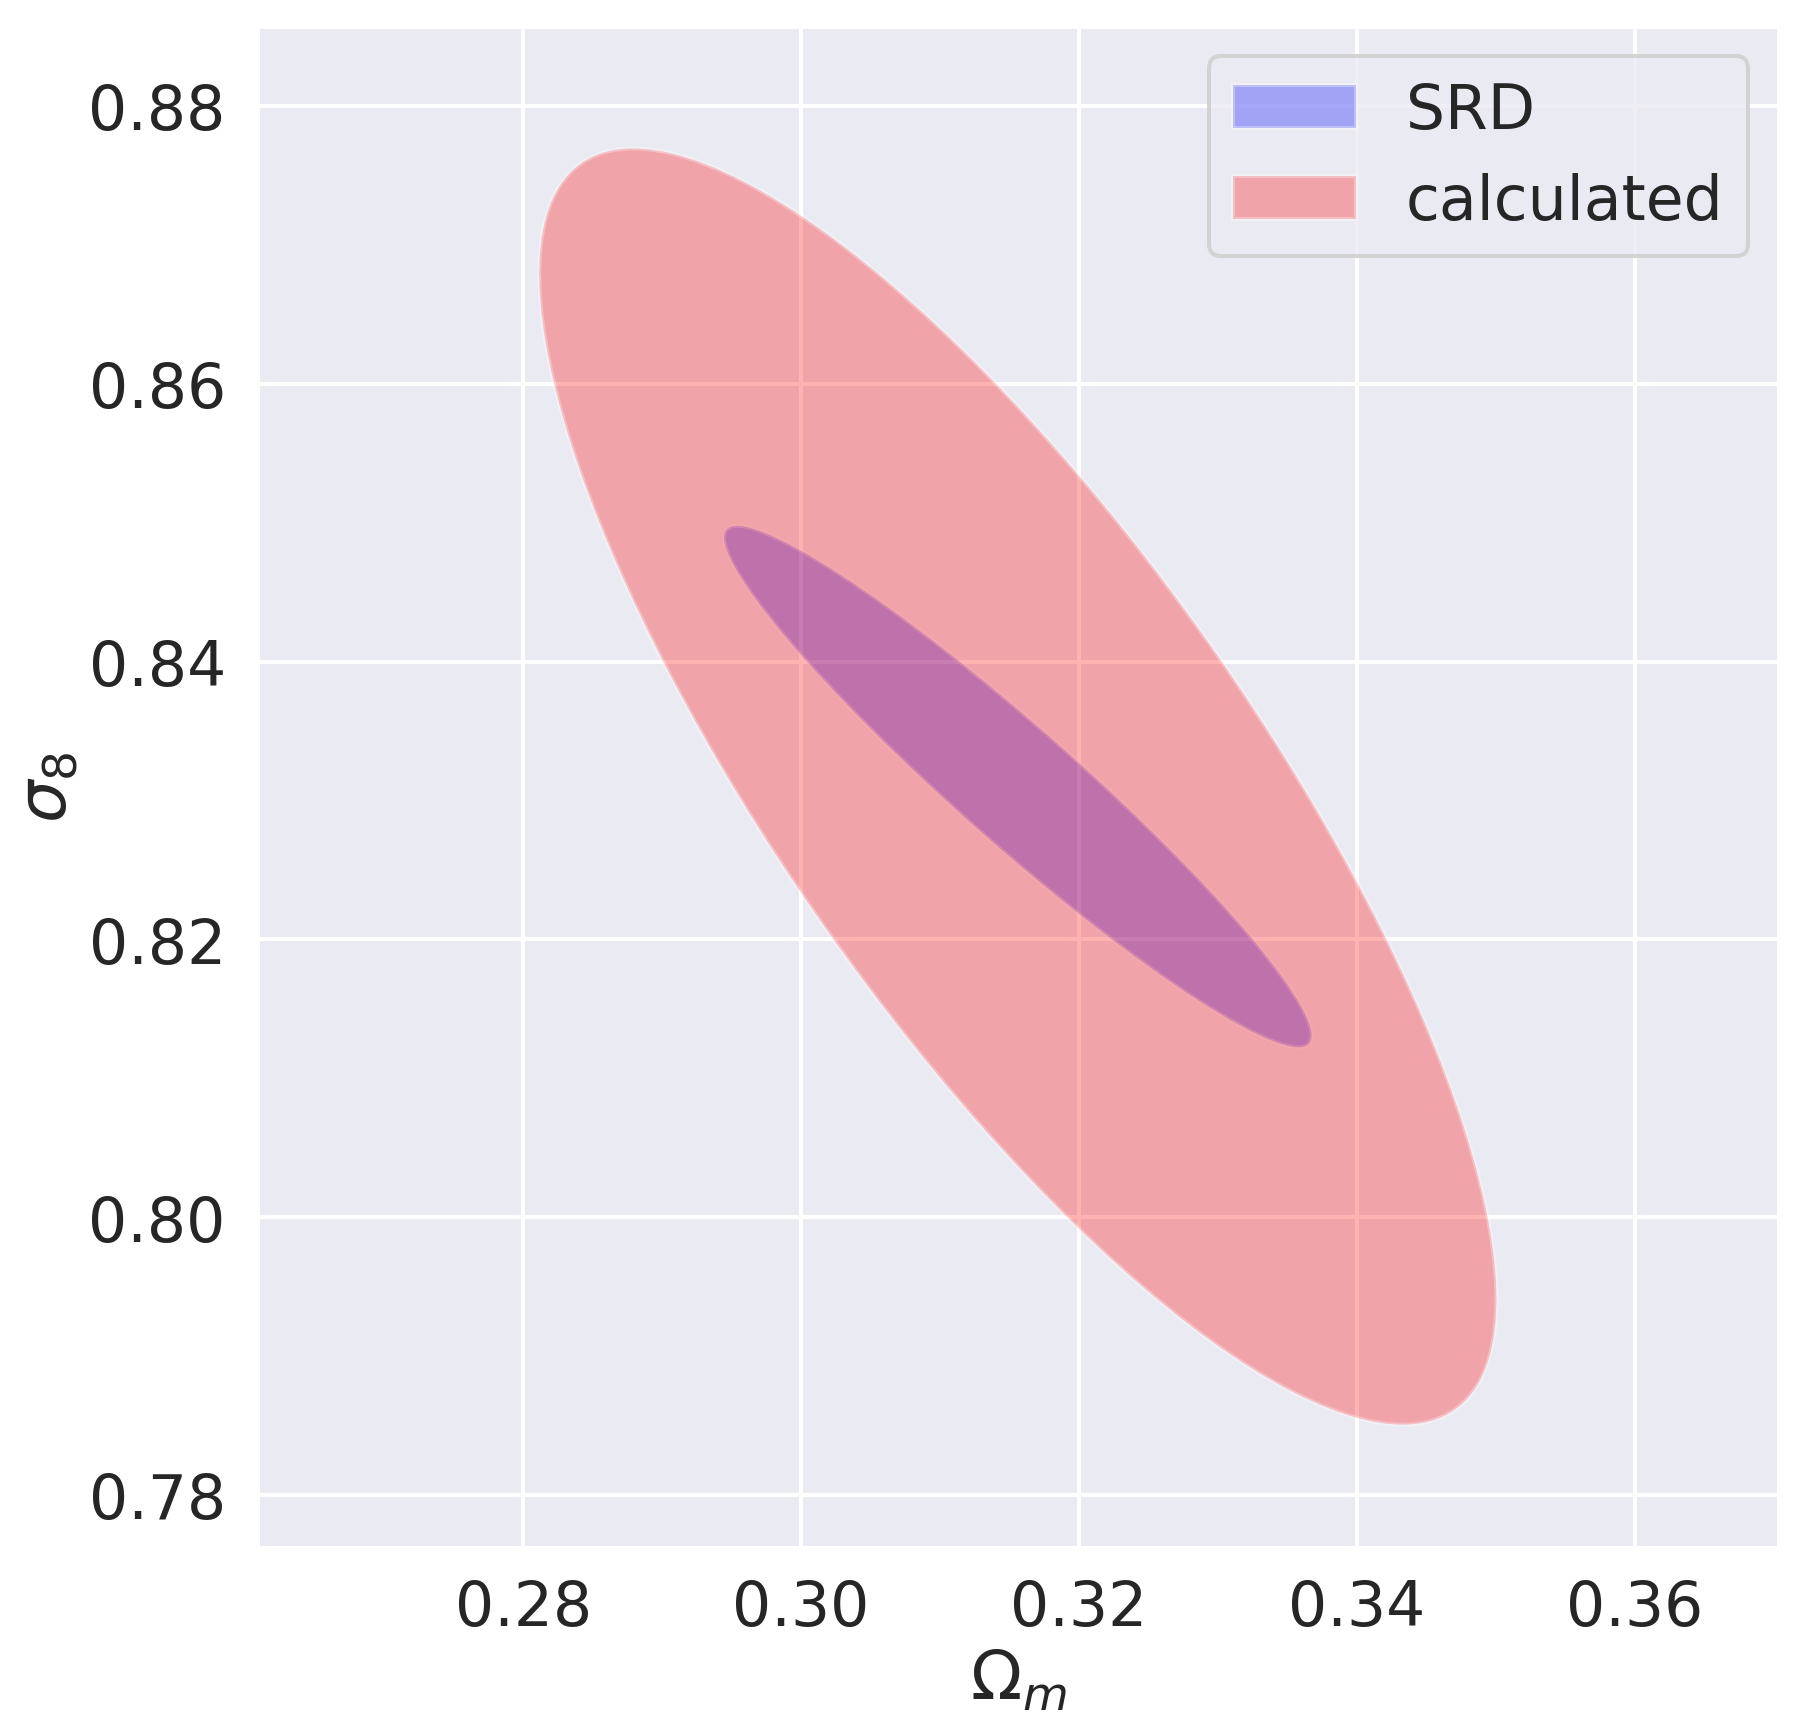

<Figure size 1368x1008 with 0 Axes>

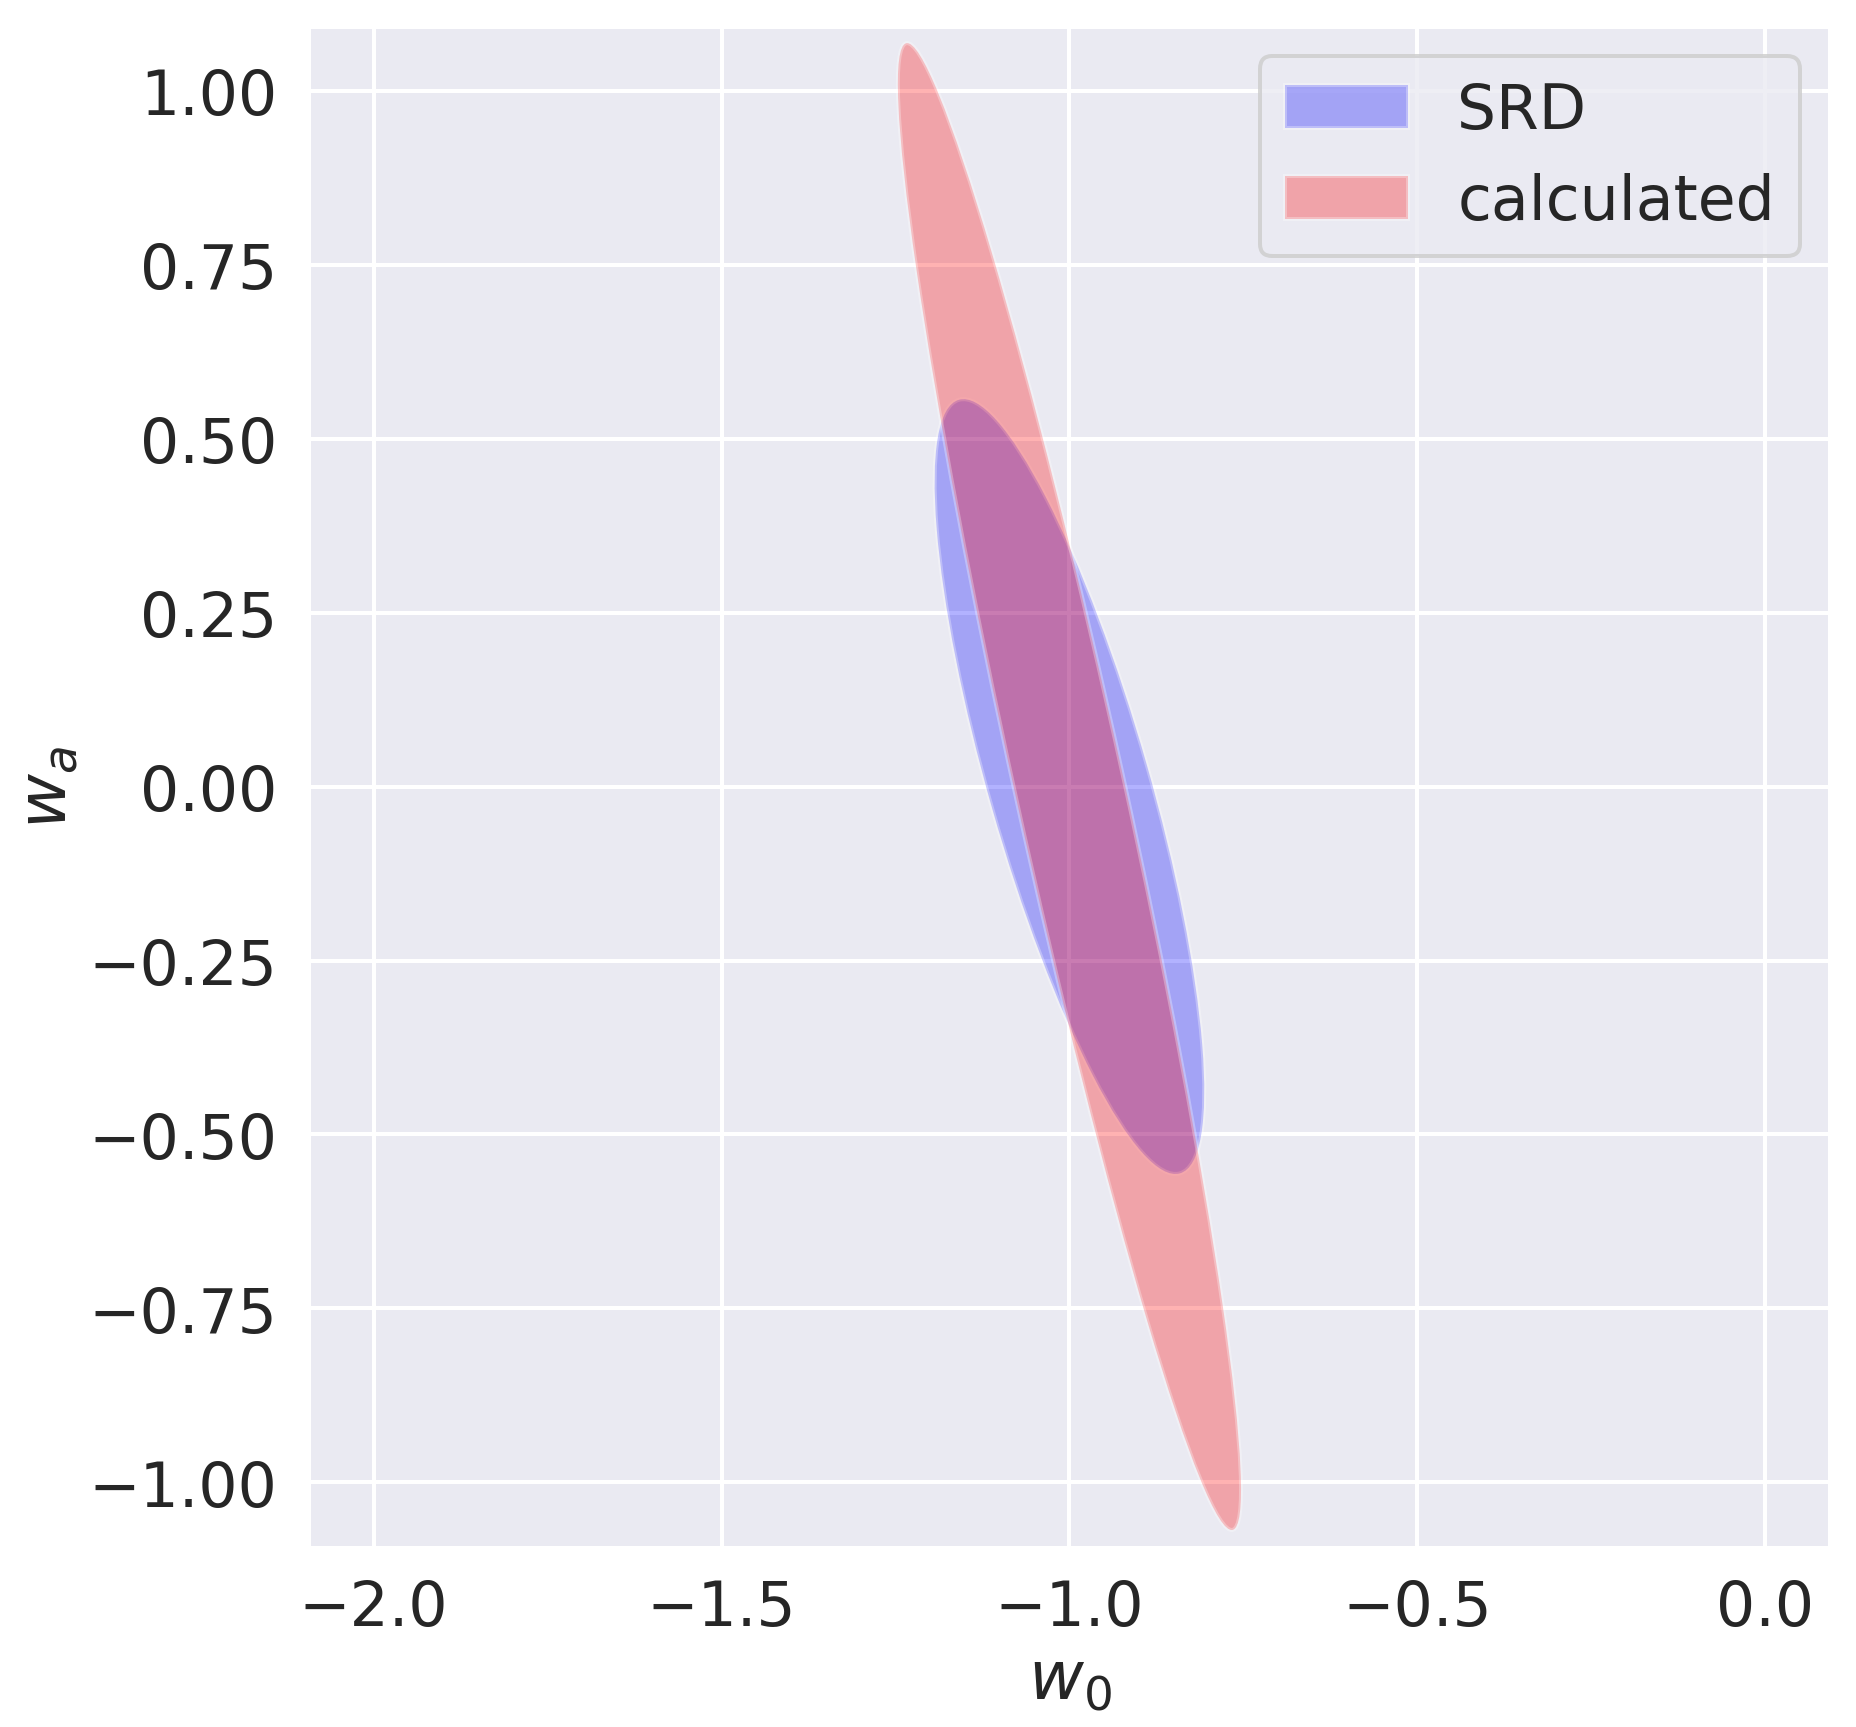

<Figure size 1368x1008 with 0 Axes>

In [330]:
colors = ['blue', 'red']
for params in [['omega_m', 'sigma_8'],
               ['w_0', 'w_a']]:
    labels = ['SRD', 'calculated']
    fid = (vals[params[0]], vals[params[1]])
    es = []
    for i, matrix in enumerate([srd_shearshear_fisher, fisher]):
        e, (xlim, ylim) = plot_contours(marginalize(matrix, param_order.index(params[0]), param_order.index(params[1])),
                          sigmas=1,
                          fid=(vals[params[0]], vals[params[1]]))
        e.set_facecolor(colors[i])
        e.set_label(labels[i])
        e.set_alpha(0.3)
        es.append(e)
    fig, ax = plt.subplots(subplot_kw={'aspect': 'equal'})

    for e in es:
        ax.add_artist(e)

    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.legend(handles=es)
    plt.xlabel(param_labels[param_order.index(params[0])])
    plt.ylabel(param_labels[param_order.index(params[1])])
    plt.figure()


# -------- Below here is under development --------

In [323]:
FoM(marginalize(srd_shearshear_fisher[np.ix_([0,1,2,3,4,5,6], [0,1,2,3,4,5,6])], 3,4))

44.31583082855116

In [162]:
FoM(marginalize(srd_shearshear_fisher, 3,4))

34.620206559980545

In [163]:
def FM_analyze(FM,FM_params):
    n_cosmo = min(7,len(FM_params))
    #print FM
    FMinv= np.linalg.inv(FM)
    covDE=FMinv[np.ix_([3,4],[3,4])]
    # for n in range(0,len(FM_params)):
    #     print("sigma(%s) = %e (no sys: %e, umarg: %e)" % (FM_params[n],np.sqrt(FMinv[n,n]),np.sqrt(FMinv_cosmo[n,n]),1./np.sqrt(FM[n,n])))
    #     print("sigma(%s) = %e (umarg: %e)" % (FM_params[n],np.sqrt(FMinv[n,n]),1./np.sqrt(FM[n,n])))
    ind_w0 = FM_params.index("w0") if "w0" in FM_params else -1 
    ind_wa = FM_params.index("wa") if "wa" in FM_params else -1 
    if ((ind_w0 > -1) & (ind_wa > -1)):
        FOM = 1./np.sqrt(FMinv[ind_w0,ind_w0]*FMinv[ind_wa,ind_wa] -FMinv[ind_w0,ind_wa]*FMinv[ind_wa,ind_w0])
        FOM2 = np.power(np.linalg.det(np.linalg.inv(covDE)),0.5)
        print("FoM = %e %e %d %d" %(FOM,FOM2,ind_wa,ind_w0))
    return FOM

In [100]:
params = ['Omega_m', 'sigma_8', 'n_s', 'w0', 'wa', 'Omega_b', 'h0', 'A', 'beta', 'eta', 'eta_high-z']

In [101]:
FM_analyze(srd_shearshear_fisher, params)

FoM = 3.462021e+01 3.462021e+01 4 3


34.620206559980545

In [240]:
import scipy

In [242]:
np.sqrt(np.linalg.det(array([[56.78300973, 13.53783378],
       [13.53783378,  6.25323872]])))

13.107431923411376

In [7]:
galaxy_bias = 1.05/ccl.growth_factor(cosmo, 1/(1+np.array(sorted(list((dNdz_dict_lens.keys()))))))



In [8]:
galaxy_bias

array([1.23136976, 1.29748196, 1.36580585, 1.43602711, 1.50787095,
       1.58110029, 1.65551247, 1.73093517, 1.80722267, 1.88425192])

In [8]:

ell = pd.read_csv('ell-values', names=['ell'])
ell = list(ell.to_dict()['ell'].values())


galaxy_bias = [1.376695e+00,
               1.451179e+00,
               1.528404e+00,
               1.607983e+00,
               1.689579e+00,
               1.772899e+00,
               1.857700e+00,
               1.943754e+00,
               2.030887e+00,
               2.118943e+00]
galaxy_bias = 1.05/ccl.growth_factor(cosmo, 1/(1+np.array(sorted(list((dNdz_dict_lens.keys()))))))
z = np.linspace(0, 4, 121)


ccl_pp = pd.DataFrame()
zbin = 0
j = 0

for key in dNdz_dict_lens.keys():
    pos = ccl.NumberCountsTracer(cosmo, has_rsd=False, dndz=(z, dNdz_dict_lens[key]), bias = (sorted(list((dNdz_dict_lens.keys()))), galaxy_bias))
    pp = ccl.angular_cl(cosmo, pos, pos, ell)
    
    newdf = pd.DataFrame({'zbin': [int(k) for k in j*np.ones(len(pp))],
                          'ell': ell,
                          'C_ell': pp})
    ccl_pp = pd.concat((ccl_pp, newdf))
    j += 1
        

ccl_cls = ccl_pp.reset_index()

In [9]:
numdens = [5.95e7]*5 
fsky = 0.4
C_ells = []
for i in set(ccl_cls['zbin']):
    C_ells.append(list(ccl_cls[ccl_cls['zbin']==i]['C_ell']))
l = []
for j in range(5):
    l.extend([[j, j+i] for i in range(5-j)])
ordering = np.array(l)
cl_bins= np.vstack((ell, C_ells)).T
cov_matrix_list = multi_bin_cov(fsky, cl_bins, ordering, numdens)

In [10]:
invcov_list = []
for cov_l in cov_matrix_list:
    invcov_list.append(np.linalg.inv(cov_l))

In [14]:
derivs_sig = {}
for var in funcs.keys():
    print(var)
    zbin = 0
    j = 0
    derivs = []
    lst = list(dNdz_dict_source.keys())
    for i, key in enumerate(lst):    
        for keyj in lst[i:]:
            f = nd.Derivative(funcs[var], full_output=True, step=0.01)
            val, info = f(vals[var])

            derivs.append(val)
    derivs_sig[var] = np.array(derivs).T

sigma_8
omega_b
h
n_s
omega_m
w_0
w_a


In [15]:
param_order = ['omega_m', 'sigma_8', 'n_s', 'w_0', 'w_a', 'omega_b', 'h']
fisher = np.zeros((7,7))
for i, var1 in enumerate(param_order):
    for j, var2 in enumerate(param_order):
        f = []
        for l in range(len(derivs_sig[var1])):
            res = derivs_sig[var1][l].T @ invcov_list[l] @ derivs_sig[var2][l]
            f.append(res)
        fisher[i][j] = sum(f)

In [16]:
fisher

array([[ 2.64460353e+07,  3.16852879e+07,  8.99826161e+06,
        -2.04915589e+06, -9.42564994e+05,  2.90737678e+07,
        -1.18055232e+06],
       [ 3.16852887e+07,  2.23453832e+08, -8.72006470e+07,
        -6.21760524e+06, -4.78472329e+06,  2.96885116e+08,
        -8.29963543e+07],
       [ 8.99826123e+06, -8.72006471e+07,  5.48653377e+07,
         1.29009740e+06,  1.61018755e+06, -1.28526574e+08,
         4.26922503e+07],
       [-2.04915590e+06, -6.21760517e+06,  1.29009736e+06,
         2.35098665e+05,  1.47180490e+05, -7.56824198e+06,
         1.74628474e+06],
       [-9.42565010e+05, -4.78472329e+06,  1.61018755e+06,
         1.47180491e+05,  1.05630486e+05, -6.20039643e+06,
         1.64978838e+06],
       [ 2.90737689e+07,  2.96885116e+08, -1.28526573e+08,
        -7.56824206e+06, -6.20039643e+06,  4.02174858e+08,
        -1.16552257e+08],
       [-1.18055266e+06, -8.29963544e+07,  4.26922503e+07,
         1.74628477e+06,  1.64978838e+06, -1.16552257e+08,
         3.5933724

In [19]:
FoM(marginalize(fisher, 3, 4))

0.029654679044296972

In [49]:
z = [0, 0.2, 0.4, 0.6, 0.8, 1, 1.2]
lum = [0.15, 0.16, 0.17, 0.19, 0.21, 0.25, 0.36]

In [50]:
from scipy.interpolate import interp1d

In [51]:
f_lum = interp1d(z, lum, fill_value='extrapolate', kind='quadratic')

In [23]:
xnew = np.linspace(0, 3.95, 100)

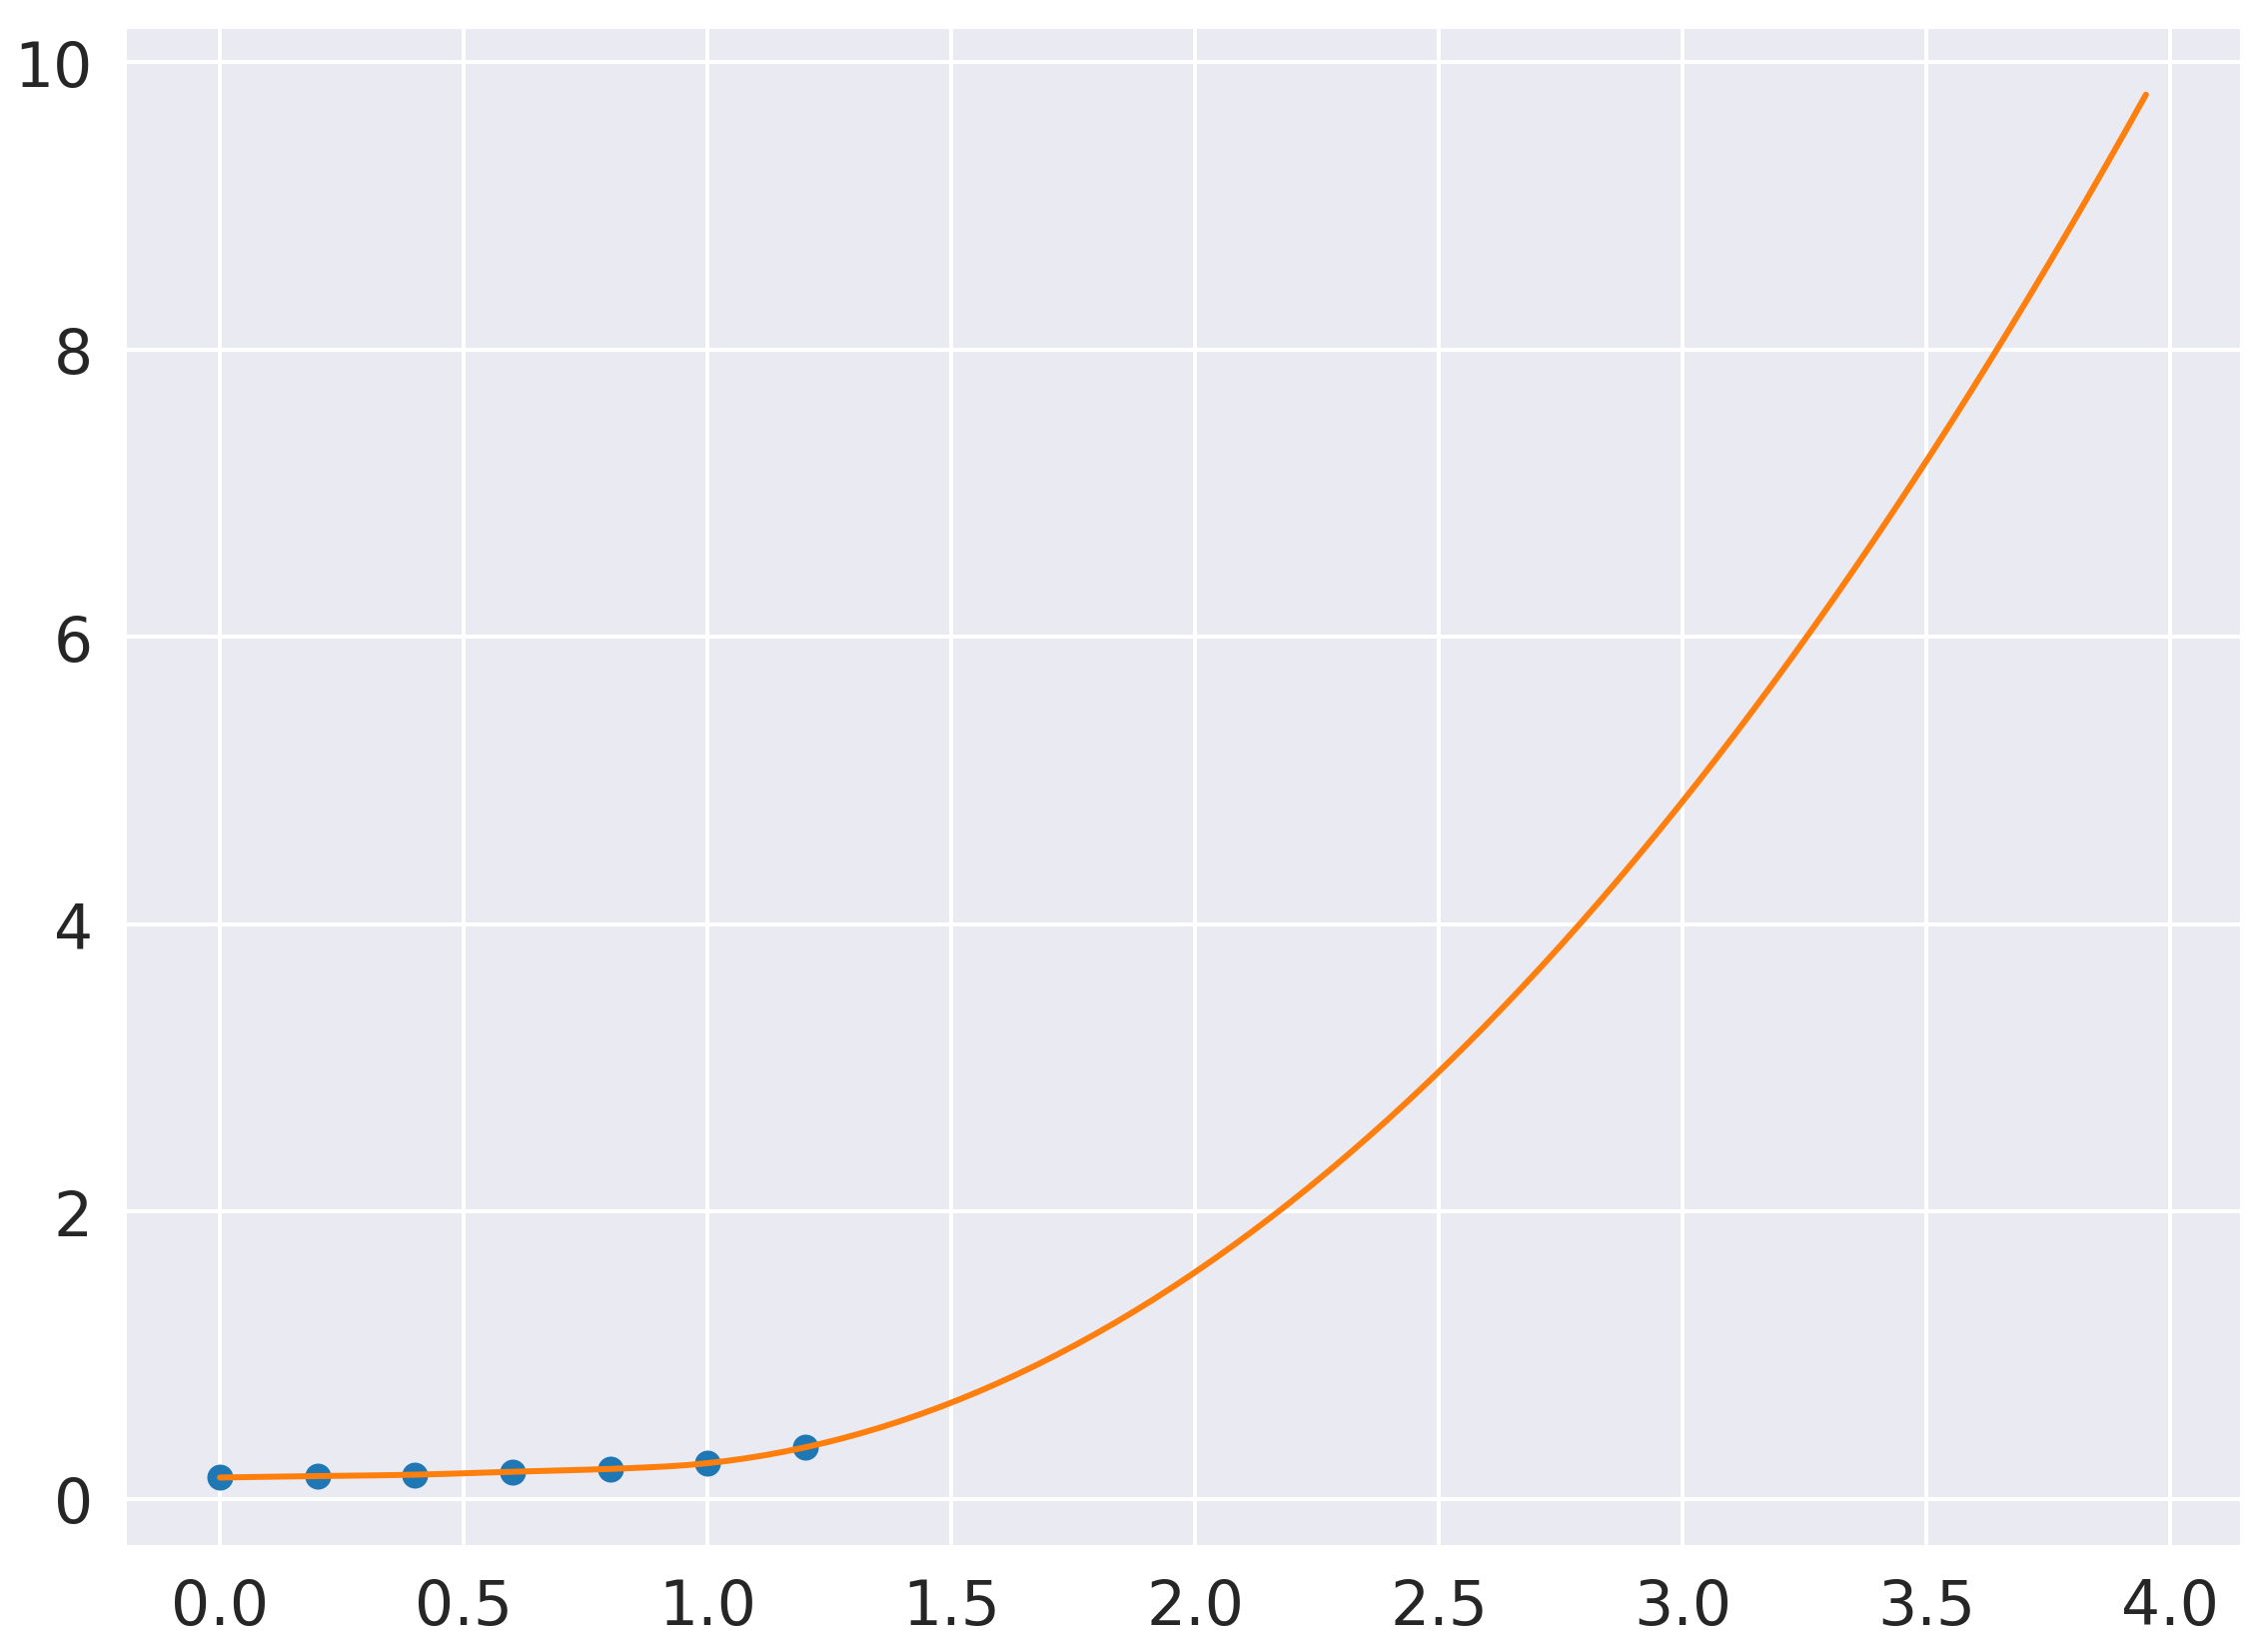

In [24]:
plt.plot(z, lum, 'o', xnew, f(xnew))

$$ A(L, z) = \frac{C_1 \rho_{m, 0}}{D(z)} A_0 (\frac{L}{L_0})^\beta (\frac{1+z}{1+z_0})^\eta $$

$$ A_0 = 5, \beta = 1, \eta = 0 $$

In [47]:
def IA(z):
    A0 = 5
    return A0 * f_lum(z) 

In [26]:
cosmo = ccl.Cosmology(Omega_c=0.2666, Omega_b=0.049, h=0.6727, sigma8=0.831, n_s=0.9645, transfer_function='eisenstein_hu')

In [52]:
z = np.linspace(0, 4, 121)

In [40]:
ell = np.linspace(10, 1000, 991)

In [89]:
j = 0
ccl_cls = pd.DataFrame()
lst = list(dNdz_dict_source.keys())
for i, key in enumerate(lst):
    lens1 = ccl.WeakLensingTracer(cosmo, dndz=(z[1:], dNdz_dict_source[key]), 
                                  ia_bias=(z[1:], IA(z[1:])), red_frac=(z[1:], np.ones_like(z[1:])*0.5))
    for keyj in lst[i:]:
        lens2 = ccl.WeakLensingTracer(cosmo, dndz=(z[1:], dNdz_dict_source[keyj]),
                                      ia_bias=(z[1:], IA(z[1:])), red_frac=(z[1:], np.ones_like(z[1:])*0.5))
        cls = ccl.angular_cl(cosmo, lens1, lens2, ell)
        newdf = pd.DataFrame({'zbin': [int(k) for k in j*np.ones(len(cls))],
                              'ell': ell,
                              'C_ell': cls})
        ccl_cls = pd.concat((ccl_cls, newdf))
        j += 1
        

ccl_cls = ccl_cls.reset_index()

In [91]:
ccl_cls[ccl_cls['ell']==100]

,index,C_ell,ell,zbin
90,90,6.189985e-07,100.0,0
1081,90,1.978396e-07,100.0,1
2072,90,6.686792e-08,100.0,2
3063,90,7.664210e-08,100.0,3
4054,90,8.731503e-08,100.0,4
5045,90,6.815247e-07,100.0,5
6036,90,1.804956e-07,100.0,6
7027,90,6.203789e-08,100.0,7
8018,90,8.081256e-08,100.0,8
9009,90,4.753984e-07,100.0,9


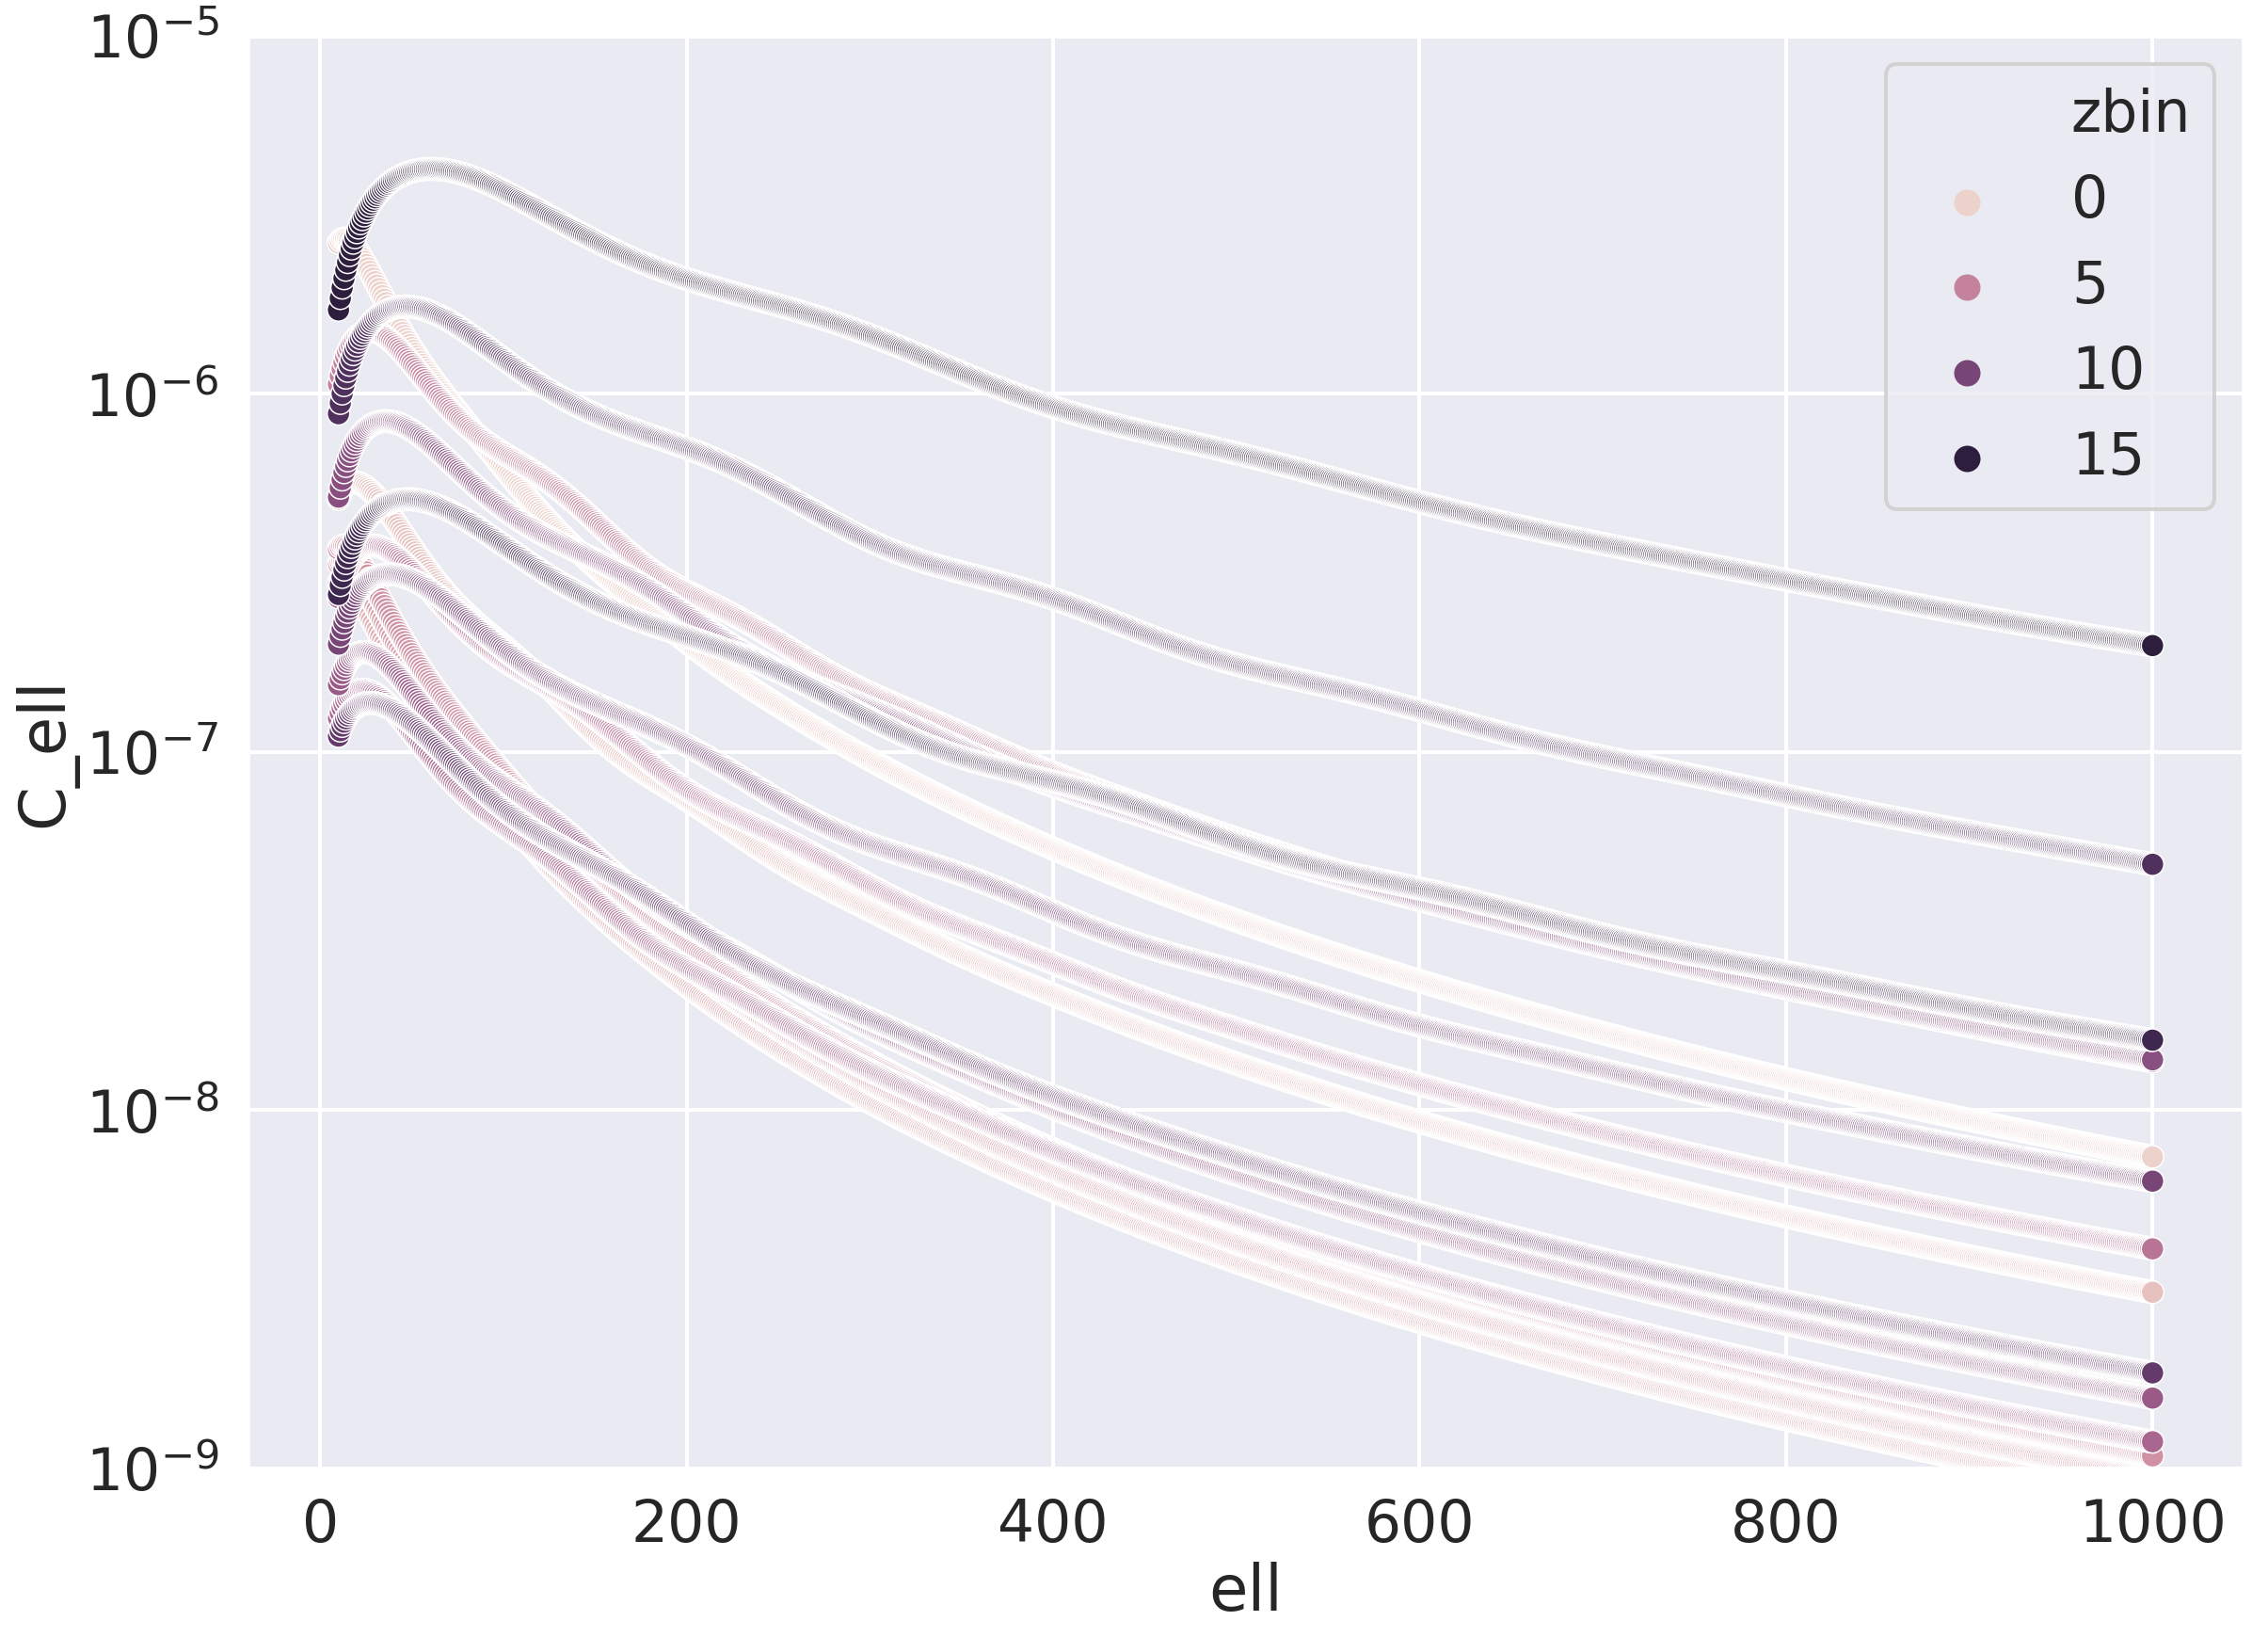

In [93]:
sns.scatterplot(x='ell', y='C_ell', data=ccl_cls, hue='zbin')
plt.ylim((1e-9, 1e-5))
plt.yscale('log')